# Mini Lab: Logistic Regression and SVMs
Billy Nayden
Sean Mcwhirter
Andrew Mejia
Rajesh Satluri

# 1) Create Models

First we will import the relevant packages for this analysis.  After the packages are imported, we build a helper funciton, import our data, and ensure the data looks satisfactory before diving into model construction.

In [1]:
import plotly
plotly.offline.init_notebook_mode()
import pandas as pd
import numpy as np 
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from pandas.plotting import boxplot
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
print(__doc__)



Automatically created module for IPython interactive environment


Below is the code that builds a helper function for learning curves. This helps us measure training time, accuracy, cross-validation score and other metrics quickly via graphs. The helper function nests multiple operations into a single function.

Next, we import our data and confirm it was loaded correctly.

In [2]:
raw_data_url = 'https://raw.githubusercontent.com/andrewmejia600/MSDS7331/master/RAW_DATA/95_cleaned_Raw_Data.csv'

In [3]:
ml_data = pd.read_csv(raw_data_url)

In [4]:
ml_data.head(n=5)

age         workclass  fnlwght  education  education_num_yr  \
0   39         State-gov    77516  Bachelors                13   
1   50  Self-emp-not-inc    83311  Bachelors                13   
2   38           Private   215646    HS-grad                 9   
3   53           Private   234721       11th                 7   
4   28           Private   338409  Bachelors                13   

       marital_status         occupation   relationship   race     sex  ...  \
0       Never-married       Adm-clerical  Not-in-family  White    Male  ...   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male  ...   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male  ...   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male  ...   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female  ...   

   annual_income  origin_descent  origin_descent_us income_outcome  \
0          <=50K   United States                  1              0   
1          <=50K   United States                  1              0   
2          <=50K   United States                  1              0   
3          <=50K   United States                  1              0   
4          <=50K           Carib                  0              0   

  level_of_employ age_range  education_level  marital_stat age_range_ord  \
0              FT     adult            CGRAD     Unmarried             2   
1              PT     adult            CGRAD       Married             2   
2              FT     adult           HSGRAD     Unmarried             2   
3              FT     adult               HS       Married             2   
4              FT     adult            CGRAD       Married             2   

  education_level_ord  
0                   6  
1                   6  
2                   3  
3                   2  
4                   6  

[5 rows x 24 columns]

Looking at our data types below we see that we have 14 *object* attributes and 10 *int64* attributes.

In [5]:
ml_data.dtypes

age                     int64
workclass              object
fnlwght                 int64
education              object
education_num_yr        int64
marital_status         object
occupation             object
relationship           object
race                   object
sex                    object
cap_gain                int64
cap_loss                int64
hours_per_week          int64
native_country         object
annual_income          object
origin_descent         object
origin_descent_us       int64
income_outcome          int64
level_of_employ        object
age_range              object
education_level        object
marital_stat           object
age_range_ord           int64
education_level_ord     int64
dtype: object

Our only column with null values is *origin_descent* which is why we will use the *origin_descent_us* attribute instead and mark all null values as 0.

In [6]:
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  30072 non-null  int64 
 1   workclass            30072 non-null  object
 2   fnlwght              30072 non-null  int64 
 3   education            30072 non-null  object
 4   education_num_yr     30072 non-null  int64 
 5   marital_status       30072 non-null  object
 6   occupation           30072 non-null  object
 7   relationship         30072 non-null  object
 8   race                 30072 non-null  object
 9   sex                  30072 non-null  object
 10  cap_gain             30072 non-null  int64 
 11  cap_loss             30072 non-null  int64 
 12  hours_per_week       30072 non-null  int64 
 13  native_country       30072 non-null  object
 14  annual_income        30072 non-null  object
 15  origin_descent       29611 non-null  object
 16  orig

Below we create a copy of our initial data set.

In [7]:
ml_data_copy = ml_data.copy()

We confirm the shape of the copied data below.

In [8]:
ml_data_copy.shape

(30072, 24)

In the below cells we address the *object* attributes. First we put them in a vector called `features_of_interest`. Next, we use OneHotEncoding to separate the *object* levels into separate columns. Then we format these as sparse matrices.

In [9]:
features_of_interest = ['workclass', 'education', 'marital_status','occupation', 'relationship', 'sex','race','origin_descent_us', 'level_of_employ', 'education_level', 'age_range', 'marital_stat']

In [10]:
tmp_cont = []
for feat in features_of_interest: 
    tmp_df = pd.get_dummies(ml_data_copy[feat],prefix=str(feat),sparse=True,drop_first=True)
    tmp_cont.append(tmp_df)
    feat_df = pd.concat(tmp_cont,axis=1)

ml_df = pd.concat([ml_data_copy,feat_df], axis=1)

ml_df.dtypes.unique()

array([dtype('int64'), dtype('O'), Sparse[uint8, 0]], dtype=object)

In [11]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 85 columns):
 #   Column                                Non-Null Count  Dtype           
---  ------                                --------------  -----           
 0   age                                   30072 non-null  int64           
 1   workclass                             30072 non-null  object          
 2   fnlwght                               30072 non-null  int64           
 3   education                             30072 non-null  object          
 4   education_num_yr                      30072 non-null  int64           
 5   marital_status                        30072 non-null  object          
 6   occupation                            30072 non-null  object          
 7   relationship                          30072 non-null  object          
 8   race                                  30072 non-null  object          
 9   sex                                   30072 non-nu

Next, we remove the *object* type attributes from our data set.

In [12]:
ml_df = ml_df.select_dtypes(include=['int64','Sparse[uint8, 0]'])

We confirm that the attributes are removed below.

In [13]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 71 columns):
 #   Column                                Non-Null Count  Dtype           
---  ------                                --------------  -----           
 0   age                                   30072 non-null  int64           
 1   fnlwght                               30072 non-null  int64           
 2   education_num_yr                      30072 non-null  int64           
 3   cap_gain                              30072 non-null  int64           
 4   cap_loss                              30072 non-null  int64           
 5   hours_per_week                        30072 non-null  int64           
 6   origin_descent_us                     30072 non-null  int64           
 7   income_outcome                        30072 non-null  int64           
 8   age_range_ord                         30072 non-null  int64           
 9   education_level_ord                   30072 non-nu

We separate our response variable `income_outcome` as `y` and the remainder of our attributes as `x`. 

In [14]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4

#https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html



ML_std_clf = StandardScaler()
#removed some redundant dummy variables
if 'income_outcome' in ml_df:
    y = ml_df['income_outcome'].values 
    del ml_df['income_outcome'] 
    X = ml_df.values 

Below we view our data set with `income_outcome` removed.

In [15]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 70 columns):
 #   Column                                Non-Null Count  Dtype           
---  ------                                --------------  -----           
 0   age                                   30072 non-null  int64           
 1   fnlwght                               30072 non-null  int64           
 2   education_num_yr                      30072 non-null  int64           
 3   cap_gain                              30072 non-null  int64           
 4   cap_loss                              30072 non-null  int64           
 5   hours_per_week                        30072 non-null  int64           
 6   origin_descent_us                     30072 non-null  int64           
 7   age_range_ord                         30072 non-null  int64           
 8   education_level_ord                   30072 non-null  int64           
 9   workclass_Local-gov                   30072 non-nu

We revisit the copy of our data set we made earlier of our initial data set so we can more easily navigate it without the sparce matrices. Here is where it becomes clear that our data is very imbalanced. Just over 24% of all people in this data set make greater than $50k per year. Which really means, we could construct a model that just predicted ~75% for all future predictions, but that is not a very useful model to generalize unseen data, and in reality may be quite biased towards the unseen data. 

In [16]:
pd.crosstab(index=ml_data_copy['income_outcome'],columns= ml_data_copy['income_outcome'])

income_outcome      0     1
income_outcome             
0               22584     0
1                   0  7488

The desparity becomes even more evident when displayed graphically.

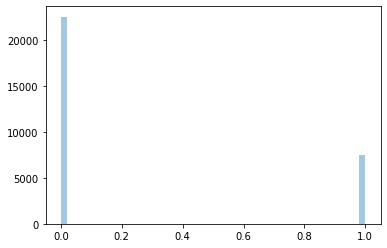

In [17]:
sns.distplot(y, kde=False)

To help handle the unbalance data set when constructing models, we can use Synthetic Minority Over-sampling (SMOTE) to over sample the class of respondents making more than $50k per year.

In [18]:
#https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

upsample_smote_ = SMOTE(sampling_strategy='not majority')
X_upsam_smote_, y_upsam_smote_ = upsample_smote_.fit_sample(X, y)

#upsample_smote_ = SMOTEENN(sampling_strategy='not majority', random_state = 959)
#X_upsam_smote_, y_upsam_smote_ = upsample_smote_.fit_sample(X, y)


The SMOTE sampling process increases the size of our data set to 45,168 rows, which can be seen below.

In [19]:
smote_df_ = pd.DataFrame(X_upsam_smote_, columns = ml_df.columns)
smote_df_['income_outcome'] = y_upsam_smote_
smote_df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45168 entries, 0 to 45167
Data columns (total 71 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   45168 non-null  float64
 1   fnlwght                               45168 non-null  float64
 2   education_num_yr                      45168 non-null  float64
 3   cap_gain                              45168 non-null  float64
 4   cap_loss                              45168 non-null  float64
 5   hours_per_week                        45168 non-null  float64
 6   origin_descent_us                     45168 non-null  float64
 7   age_range_ord                         45168 non-null  float64
 8   education_level_ord                   45168 non-null  float64
 9   workclass_Local-gov                   45168 non-null  float64
 10  workclass_Private                     45168 non-null  float64
 11  workclass_Self-

We can see in the cross tab and histogram below, that now the data set is balanced between the two classes. The SMOTE is randomly picking samples from the minority class, while not adding to the majority class. This is what we wanted to improve the training and test cross valdation data sets. It should be noted, the inherent risk of using such a techinque without using a cross validation test set will be having the model being overfit to the training data set. Therefore, we will conduct 3 fold cross validation when constructing the models with 80% of the data being the train set and 20% being the test set. 

We used the SMOTE technique due to, even after adjusting the model paramaters using the original stratification of the data set, the best accuarcy score we obtained was ~78% accuracy. This is largely due to the imbalanced classes of the data set as seen from the histogram of the original data as previously discussed and revewing the histogram of the outcome classes below. 

In [20]:
pd.crosstab(index=smote_df_['income_outcome'],columns= smote_df_['income_outcome'])

income_outcome      0      1
income_outcome              
0               22584      0
1                   0  22584

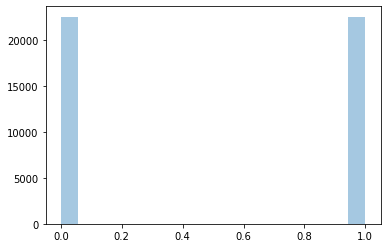

In [21]:
sns.distplot(y_upsam_smote_, kde=False)


Below we perform an 80/20 test train split on the data set, and create three separate iterations of this split for testing. Even though we used SMOTE to obtain the same proportion of our target variable (income_outcome), we use stratified cross validation to ensure that we have the same proportions in our test/train splits.  Additionally, we use a random_state of 959 to ensure we are using the same samples with our logistic regression and support vector machines models.

In [22]:
#https://scikit-learn.org/0.15/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
num_cv_iterations = 3
#num_instances = len(y)
#num_instances_smote_ = len(y_upsam_smote_)

cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state = 959)


                         
print(cv_object)


StratifiedShuffleSplit(n_splits=3, random_state=959, test_size=0.2,
            train_size=None)


## Logistic Regression Models


### LOGISTIC REGRESSION MODEL 1 -- LR Full
Below is our first logisitc regression model with OneHotEncoded binary and categorical data, using an 80/20 test/train split.  We also make a logistic regression pipeline using StandardScalar to scale our data as the continuous variables are on very different scales, e.g. age and cap_gains. We also evaluate the runtime as part of the performance evaluation.  We also include the AUC score in addition to our main metric of accuracy to ensure we are not ignoring signals of a flimsy accuracy score.

In [23]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
##https://docs.python.org/3/library/time.html#functions




#lr_clf = LogisticRegression(penalty='elasticnet', C=1.0, class_weight=None, solver='saga', l1_ratio = 0.5 )
lr_clf = LogisticRegression(penalty='l2', C=.5, class_weight=None, solver='liblinear', max_iter=1e6)

lr_clf_pipe = make_pipeline(StandardScaler(),lr_clf)


iter_num=0
weights_full = []
accuracies_full = []
auc_scores_full = []
runtimes_full = []

for train_indices, test_indices in cv_object.split(X,y): 

    t = time.process_time()
    
    lr_clf_pipe.fit(X[train_indices], y[train_indices])
    y_hat = lr_clf_pipe.predict(X[test_indices]) # get test set precitions
    
    elapsed_time = time.process_time() - t
    

    # now let's get the accuracy and confusion matrix for these iterations of training/testing
    acc = mt.accuracy_score(y[test_indices],y_hat)
    f1_scor_ = mt.f1_score(y[test_indices],y_hat)
    prec_scor_ = mt.precision_score(y[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    
    weights_full.append(lr_clf_pipe.named_steps['logisticregression'].coef_[0])
    accuracies_full.append(acc)
    auc_scores_full.append(auc_scor_)
    runtimes_full.append(elapsed_time)
    

  

    iter_num+=1

#Mean accuracy/f1/and train time for later comparison

mean_accuracy_full = (sum(accuracies_full)/len(accuracies_full))*100
mean_auc_score_full = (sum(auc_scores_full)/len(auc_scores_full))*100
mean_runtimes_full = (sum(runtimes_full)/len(runtimes_full))

print("The mean accuracy of the full logistic regression model is ", mean_accuracy_full, "%")
print("The mean AUC score of the full logistic regression model is ", mean_auc_score_full, "%")
print("The mean Train Time of the full logistic regression model is ", mean_runtimes_full, "seconds")


====Iteration 0  ====

Accuracy:  0.8443890274314214 

f1_score: 0.6640344580043072 

precision_score: 0.718167701863354 

roc_auc_score: 0.7685634569064561 

Confusion Matrix: 

      0    1
0  4154  363
1   573  925 

Train Time:  1.62061783 s

====Iteration 1  ====

Accuracy:  0.8468827930174564 

f1_score: 0.6644808743169399 

precision_score: 0.731355252606255 

roc_auc_score: 0.7673237403394918 

Confusion Matrix: 

      0    1
0  4182  335
1   586  912 

Train Time:  1.8285191520000001 s

====Iteration 2  ====

Accuracy:  0.8470490440565254 

f1_score: 0.6582466567607728 

precision_score: 0.7420435510887772 

roc_auc_score: 0.761634212009637 

Confusion Matrix: 

      0    1
0  4209  308
1   612  886 

Train Time:  1.950599758 s

The mean accuracy of the full logistic regression model is  84.61069548351344 %
The mean AUC score of the full logistic regression model is  76.58404697518615 %
The mean Train Time of the full logistic regression model is  1.7999122466666666 seconds


As we can see from the results above, we get a mean accuracy of 84.61%. We feel that we can improve upon our mean accuracy score. Our mean AUC score is 76.58%, meaning our model is predicting 26.58% better than the chance of flipping a coin. And we can see the mean training and test time is 1.208 seconds. 

In [24]:
#weights_full

Looking at weight outputs from the logistic regression model, we can see the features that the model scored with the highest mean weights that positively and negatively effecct the model are : 
age, education_num_yr, cap_gain, relationship_Not-in-family, relationship_Other-relative, relationship_Own-child, relationship_Unmarried, relationship_Wife, sex_Male, age_range_child, age_range_senior. 
The important thing to note here, is while some of these features are engineered, there seems to be some interaction between certain features and response. As this model is being used for prediction purposes, we will keep these features in our reduced model. We see, by far capital gains is the largest contributor to the predicted outcome. 

In [25]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4

error_y=dict(
            type='data',
            array=np.std(weights_full,axis=0),
            visible=True
        )

graph1 = {'x': ml_df.columns,
          'y': np.mean(weights_full,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars (Full Model)', 'height': 1000, 'width': 1400, 'font': {'size':14}}
plotly.offline.iplot(fig)


### LOGISTIC REGRESSION MODEL 2 -- LR Reduced

Let's select the important variables from chart above and look at age, education_num_yr, cap_gain, relationship_Not-in-family, relationship_Other-relative, relationship_Own-child, relationship_Unmarried, relationship_Wife, sex_Male, age_range_child, age_range_senior. We can expect the Train Time to decrease significantly given that we are using fewer attributes, but we will see how drastically our accuracy and AUC scores change.

In [26]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4
Xnew = ml_df[['age', 'education_num_yr', 'cap_gain', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'sex_Male', 'age_range_child', 'age_range_senior']].values

weights_reduced = []
accuracies_reduced = []
auc_scores_reduced = []
runtimes_reduced = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    lr_clf_pipe.fit(Xnew[train_indices],y[train_indices])
    
    weights_reduced.append(lr_clf_pipe.named_steps['logisticregression'].coef_[0])
    iter_num =+1
    
weights_reduced = np.array(weights_reduced)

error_y=dict(
            type='data',
            array=np.std(weights_reduced,axis=0),
            visible=True
        )

graph1 = {'x': ['age', 'education_num_yr', 'cap_gain', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'sex_Male', 'age_range_child', 'age_range_senior'],
          'y': np.mean(weights_reduced,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars (Reduced Model)', 'height': 1000, 'width': 1400, 'font': {'size':14}}

plotly.offline.iplot(fig)

In [27]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    
    
    t = time.process_time()
    lr_clf_pipe.fit(Xnew[train_indices],y[train_indices])
    
    y_hat = lr_clf_pipe.predict(Xnew[test_indices])
    
    elapsed_time = time.process_time() - t
    


    acc = mt.accuracy_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    f1_scor_ = mt.f1_score(y[test_indices],y_hat)
    prec_scor_ = mt.precision_score(y[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    
    accuracies_reduced.append(acc)
    auc_scores_reduced.append(auc_scor_)
    runtimes_reduced. append(elapsed_time)
    

    print("====Iteration",iter_num," ====\n")
    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    iter_num+=1

    
#Mean accuracy/f1/and train time for later comparison

mean_accuracy_reduced = (sum(accuracies_reduced)/len(accuracies_reduced))*100
mean_auc_score_reduced = (sum(auc_scores_reduced)/len(auc_scores_reduced))*100
mean_runtime_reduced = (sum(runtimes_reduced)/len(runtimes_reduced))
    
print("The mean accuracy of the reduced logistic regression model is ", mean_accuracy_reduced, "%")
print("The mean AUC score of the reduced logistic regression model is ", mean_auc_score_reduced, "%")
print("The mean Train Time of the reduced logistic regression model is ", mean_runtime_reduced, "seconds")


====Iteration 0  ====

Accuracy:  0.8335827098919368 

f1_score: 0.6241081487044687 

precision_score: 0.7133047210300429 

roc_auc_score: 0.740398385213197 

Confusion Matrix: 

      0    1
0  4183  334
1   667  831 

Train Time:  0.12888079700000077 s

====Iteration 1  ====

Accuracy:  0.8314214463840399 

f1_score: 0.6190833959429001 

precision_score: 0.7079037800687286 

roc_auc_score: 0.7373977789883227 

Confusion Matrix: 

      0    1
0  4177  340
1   674  824 

Train Time:  0.4416151509999988 s

====Iteration 2  ====

Accuracy:  0.8370739817123857 

f1_score: 0.6216216216216217 

precision_score: 0.7371794871794872 

roc_auc_score: 0.7369227156391535 

Confusion Matrix: 

      0    1
0  4230  287
1   693  805 

Train Time:  0.503437163000001 s

The mean accuracy of the reduced logistic regression model is  83.40260459961209 %
The mean AUC score of the reduced logistic regression model is  73.82396266135576 %
The mean Train Time of the reduced logistic regression model is  0

Observing the results above, we can see that narrowing down the attributes to those with the highest weights, we didn't take a significant hit on the mean accuracy or AUC scores.  We will dive further into the differneces in the Model Advantages section, but it seems we have saved significant time and only sacrificed minimal accuracy and AUC. 

### LOGISTIC REGRESSION MODEL 3 -- LR SMOTE


Here we use Logistic Regression and upsample the minority population of those making over $50,000 using SMOTE.  When upsampling our minority variable of over 50,000, we need to keep in mind that there is a potential danger of overfitting.

In [28]:
lr_clf = LogisticRegression(penalty='l2', C=0.1, class_weight=None, solver='sag', max_iter=1e6 )
#lr_clf = LogisticRegression(penalty='l2', C=1, class_weight=None, solver='liblinear', max_iter=1e6)
lr_clf_pipe = make_pipeline(StandardScaler(),lr_clf)


iter_num=0
weights_smote = []
accuracies_smote = []
auc_scores_smote = []
runtimes_smote = []


for train_indices, test_indices in cv_object.split(X_upsam_smote_,y_upsam_smote_): 

    t = time.process_time()
    
    lr_clf_pipe.fit(X_upsam_smote_[train_indices], y_upsam_smote_ [train_indices])
    y_hat = lr_clf_pipe.predict(X_upsam_smote_[test_indices]) # get test set precitions
    
    elapsed_time = time.process_time() - t
    

    # now let's get the accuracy and confusion matrix for these iterations of training/testing
    acc = mt.accuracy_score(y_upsam_smote_ [test_indices],y_hat)
    f1_scor_ = mt.f1_score(y_upsam_smote_ [test_indices],y_hat)
    prec_scor_ = mt.precision_score(y_upsam_smote_ [test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y_upsam_smote_ [test_indices],y_hat)
    conf = mt.confusion_matrix(y_upsam_smote_ [test_indices],y_hat)
    
    accuracies_smote.append(acc)
    auc_scores_smote.append(auc_scor_)
    runtimes_smote.append(elapsed_time)
    
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    
    weights_smote.append(lr_clf_pipe.named_steps['logisticregression'].coef_[0])
    iter_num+=1

weights_smote = np.array(weights_smote)

#Mean accuracy/f1/and train time for later comparison

mean_accuracy_smote = (sum(accuracies_smote)/len(accuracies_smote))*100
mean_auc_score_smote = (sum(auc_scores_smote)/len(auc_scores_smote))*100
mean_runtime_smote = (sum(runtimes_smote)/len(runtimes_smote))

print("The mean accuracy of the SMOTE logistic regression model is", mean_accuracy_smote, "%")
print("The mean AUC score of the SMOTE logistic regression model is", mean_auc_score_smote, "%")
print("The mean Train TIme for the SMOTE logistic regression model is ", mean_runtime_smote, "seconds")

====Iteration 0  ====

Accuracy:  0.8274297099845029 

f1_score: 0.8328508630856654 

precision_score: 0.8074844074844075 

roc_auc_score: 0.827429709984503 

Confusion Matrix: 

      0     1
0  3591   926
1   633  3884 

Train Time:  3.295695789 s

====Iteration 1  ====

Accuracy:  0.837170688510073 

f1_score: 0.8407491609830031 

precision_score: 0.8226694915254237 

roc_auc_score: 0.8371706885100731 

Confusion Matrix: 

      0     1
0  3680   837
1   634  3883 

Train Time:  3.4338509110000004 s

====Iteration 2  ====

Accuracy:  0.8332964356874032 

f1_score: 0.8374001295616498 

precision_score: 0.8172813487881981 

roc_auc_score: 0.8332964356874031 

Confusion Matrix: 

      0     1
0  3650   867
1   639  3878 

Train Time:  3.569110733999999 s

The mean accuracy of the SMOTE logistic regression model is 83.26322780606597 %
The mean AUC score of the SMOTE logistic regression model is 83.26322780606597 %
The mean Train TIme for the SMOTE logistic regression model is  3.432885

In [29]:
error_y=dict(
            type='data',
            array=np.std(weights_smote,axis=0),
            visible=True
        )

graph1 = {'x': ml_df.columns,
          'y': np.mean(weights_smote,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars (SMOTE Model)', 'height': 1000, 'width': 1400, 'font': {'size':14}}
plotly.offline.iplot(fig)

### LOGISTIC REGRESSION MODEL 4 -- LR SMOTE Reduced


Here we use a grid search to select the best parameters for our SMOTE model. After we are able to select the best parameters, we will rerun our upsampled logistic regression model with the highest-weighted attributes from our LR SMOTE model(age, cap_gain, sex_Male, hours_per_week, and educaiton _num_yr). 

In [30]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py
#https://scikit-learn.org/stable/modules/grid_search.html#gridsearch-scoring
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
#https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline


tuned_parameters = [{'logisticregression__C': [1e-1, 0.5, 1], 
                     'logisticregression__max_iter' : [1e6], 
                     'logisticregression__penalty' : ['l2'], 
                     'logisticregression__class_weight' : [None, 'balanced'], 
                     'logisticregression__solver' : ['sag', 'liblinear']
                    }]


lr_clf_cv = LogisticRegression()

lr_clf_pipe_cv = make_pipeline(StandardScaler(),lr_clf_cv)

clf = GridSearchCV(lr_clf_pipe_cv, param_grid = tuned_parameters, scoring='accuracy', cv=cv_object)

clf.fit(X_upsam_smote_, y_upsam_smote_)

    
print(clf.best_params_)

{'logisticregression__C': 0.5, 'logisticregression__class_weight': None, 'logisticregression__max_iter': 1000000.0, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'sag'}


In [31]:
#Xnew_smote_ = ml_df[['age','cap_gain','sex_Male', 'marital_stat_Unmarried', 'marital_status_Married-civ-spouse', 'education_Preschool','education_Prof-school']].values

Xnew_smote_ = ml_df[['age','cap_gain','sex_Male', 'hours_per_week', 'education_num_yr']].values

Xnew_upsam_smote_, ynew_upsam_smote_ = upsample_smote_.fit_sample(Xnew_smote_, y)

weights_smote_reduced = []
accuracies_smote_reduced = []
auc_scores_smote_reduced = []
runtimes_smote_reduced = []


for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew_upsam_smote_, ynew_upsam_smote_)):
    lr_clf_pipe.fit(Xnew_upsam_smote_[train_indices],ynew_upsam_smote_[train_indices])
    
    weights_smote_reduced.append(lr_clf_pipe.named_steps['logisticregression'].coef_[0])
    iter_num =+1
    
weights_smote_reduced = np.array(weights_smote_reduced)

error_y=dict(
            type='data',
            array=np.std(weights_smote_reduced,axis=0),
            visible=True
        )

graph1 = {#'x': ['age','cap_gain','sex_Male', 'marital_stat_Unmarried', 'marital_status_Married-civ-spouse', 'education_Preschool','education_Prof-school'],
          'x': ['age','cap_gain','sex_Male', 'hours_per_week', 'education_num_yr'],
          'y': np.mean(weights_smote_reduced,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars (Reduced SMOTE Model)', 'height': 1000, 'width': 1400, 'font': {'size':14}}

plotly.offline.iplot(fig)

    


In [32]:
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew_upsam_smote_, ynew_upsam_smote_)):
    
   
    
    t = time.process_time()
    lr_clf_pipe.fit(Xnew_upsam_smote_[train_indices],ynew_upsam_smote_[train_indices])
    
    y_hat = lr_clf_pipe.predict(Xnew_upsam_smote_[test_indices])
    
    elapsed_time = time.process_time() - t
    


    acc = mt.accuracy_score(ynew_upsam_smote_[test_indices],y_hat)
    conf = mt.confusion_matrix(ynew_upsam_smote_[test_indices],y_hat)
    f1_scor_ = mt.f1_score(ynew_upsam_smote_[test_indices],y_hat)
    prec_scor_ = mt.precision_score(ynew_upsam_smote_[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(ynew_upsam_smote_[test_indices],y_hat)
    conf = mt.confusion_matrix(ynew_upsam_smote_[test_indices],y_hat)
    
    accuracies_smote_reduced.append(acc)
    auc_scores_smote_reduced.append(auc_scor_)
    runtimes_smote_reduced.append(elapsed_time)
    
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")

    iter_num+=1


#Mean accuracy/f1/and train time for later comparison

mean_accuracy_smote_reduced = (sum(accuracies_smote_reduced)/len(accuracies_smote_reduced))*100
mean_auc_score_smote_reduced = (sum(auc_scores_smote_reduced)/len(auc_scores_smote_reduced))*100
mean_runtime_smote_reduced = (sum(runtimes_smote_reduced)/len(runtimes_smote_reduced))

print("The mean accuracy of the reduced SMOTE logistic regression model is", mean_accuracy_smote_reduced, "%")
print("The mean AUC score of the reduced SMOTE logistic regression model is", mean_auc_score_smote_reduced, "%")
print("The mean Train TIme for the reduced SMOTE logistic regression model is ", mean_runtime_smote_reduced, "seconds")

====Iteration 0  ====

Accuracy:  0.7560327651095861 

f1_score: 0.75456570155902 

precision_score: 0.7591306296213309 

roc_auc_score: 0.756032765109586 

Confusion Matrix: 

      0     1
0  3442  1075
1  1129  3388 

Train Time:  0.21014503600000012 s

====Iteration 1  ====

Accuracy:  0.75680761567412 

f1_score: 0.7524507042253521 

precision_score: 0.7661771454795778 

roc_auc_score: 0.75680761567412 

Confusion Matrix: 

      0     1
0  3498  1019
1  1178  3339 

Train Time:  0.5021159739999916 s

====Iteration 2  ====

Accuracy:  0.7600177108700464 

f1_score: 0.7587894971072541 

precision_score: 0.7626929098635652 

roc_auc_score: 0.7600177108700465 

Confusion Matrix: 

      0     1
0  3456  1061
1  1107  3410 

Train Time:  0.4611263200000053 s

The mean accuracy of the reduced SMOTE logistic regression model is 75.76193638845842 %
The mean AUC score of the reduced SMOTE logistic regression model is 75.76193638845842 %
The mean Train TIme for the reduced SMOTE logistic r

Below we store the mean accuracy, AUC scores, and train times in a tabualar form to make it easier to compare model advantages later on.

In [33]:
#Creating a dataframe to store and review when discussing model advantages
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html

lr_scores = {'Model' : ['LR Full', 'LR Reduced', 'LR SMOTE', 'LR Rduced SMOTE'], 'Accuracy' : [mean_accuracy_full, mean_accuracy_reduced, mean_accuracy_smote, mean_accuracy_smote_reduced], 'AUC Score' : [mean_auc_score_full, mean_auc_score_reduced, mean_auc_score_smote, mean_auc_score_smote_reduced],'Train Time' : [mean_runtimes_full, mean_runtime_reduced, mean_runtime_smote, mean_runtime_smote_reduced]}

In [34]:
lr_summary = pd.DataFrame(data=lr_scores)
lr_summary

Model   Accuracy  AUC Score  Train Time
0          LR Full  84.610695  76.584047    1.799912
1       LR Reduced  83.402605  73.823963    0.357978
2         LR SMOTE  83.263228  83.263228    3.432886
3  LR Rduced SMOTE  75.761936  75.761936    0.391129

## SVM Models


### SVM Model 1 -- SVC-rbf 

Our first SVM model will use the rbf kernel and automatic gamma to reduce train time.

In [35]:
svm_clf = SVC(C=0.5, kernel='rbf', gamma='auto') 


accuracy_SVC_rbf_GA=[]
auc_SVC_rbf_GA=[]
runtime_SVC_rbf_GA=[]

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_upsam_smote_,y_upsam_smote_)): 
    

    ML_std_clf.fit(X_upsam_smote_[train_indices])
    X_train_scaled = ML_std_clf.transform(X_upsam_smote_[train_indices]) 
    X_test_scaled = ML_std_clf.transform(X_upsam_smote_[test_indices]) 
    
    t = time.process_time()

    svm_clf.fit(X_train_scaled, y_upsam_smote_[train_indices])  

    y_hat = svm_clf.predict(X_test_scaled)
    
    elapsed_time = time.process_time() - t

    acc = mt.accuracy_score(y_upsam_smote_[test_indices],y_hat)
    f1_scor_ = mt.f1_score(y_upsam_smote_[test_indices],y_hat)
    prec_scor_ = mt.precision_score(y_upsam_smote_[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y_upsam_smote_[test_indices],y_hat)
    conf = mt.confusion_matrix(y_upsam_smote_[test_indices],y_hat)
    
    accuracy_SVC_rbf_GA.append(acc)
    auc_SVC_rbf_GA.append(auc_scor_)
    runtime_SVC_rbf_GA.append(elapsed_time)
    
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    iter_num =+1
    
mean_accuracy_SVC_rbf_GA=sum(accuracy_SVC_rbf_GA)/len(accuracy_SVC_rbf_GA)*100
mean_auc_SVC_rbf_GA=sum(auc_SVC_rbf_GA)/len(auc_SVC_rbf_GA)*100
mean_runtime_SVC_rbf_GA=sum(runtime_SVC_rbf_GA)/len(runtime_SVC_rbf_GA)

print('The mean accuracy of SVC with the rbf kernel and automatic gamma is ',mean_accuracy_SVC_rbf_GA,'%')
print('The mean AUC Score of SVC with the rbf kernel and automatic gamma is ',mean_auc_SVC_rbf_GA,'%')
print('The mean Train Time of SVC with the rbf kernel and automatic gamma is ',mean_runtime_SVC_rbf_GA,'seconds')

====Iteration 0  ====

Accuracy:  0.8709320345361966 

f1_score: 0.8713592233009709 

precision_score: 0.8684847151968331 

roc_auc_score: 0.8709320345361967 

Confusion Matrix: 

      0     1
0  3919   598
1   568  3949 

Train Time:  103.147953167 s

====Iteration 1  ====

Accuracy:  0.8749169802966571 

f1_score: 0.8740806775128148 

precision_score: 0.8799641014135069 

roc_auc_score: 0.8749169802966572 

Confusion Matrix: 

      0     1
0  3982   535
1   595  3922 

Train Time:  101.34847661000003 s

====Iteration 2  ====

Accuracy:  0.8773522249280495 

f1_score: 0.876834148510449 

precision_score: 0.8805536950212101 

roc_auc_score: 0.8773522249280497 

Confusion Matrix: 

      0     1
0  3982   535
1   573  3944 

Train Time:  106.17596999900002 s

The mean accuracy of SVC with the rbf kernel and automatic gamma is  87.44004132536345 %
The mean AUC Score of SVC with the rbf kernel and automatic gamma is  87.44004132536345 %
The mean Train Time of SVC with the rbf kernel and

### SVM Model 2 -- SGDClassifier

Here, we use stochastic gradient descent via SGDClassifier.  Using SGD, we can run multiple iterations quickly given the large size of our data set.  We also used tuned parameters to optimize our model.


In [36]:
#SDG parameter best search
tuned_parameters = [{'sgdclassifier__alpha': [1e-3,1e-2, 1e-1], 
                     'sgdclassifier__fit_intercept' : [True],
                     'sgdclassifier__l1_ratio' : [0],
                     'sgdclassifier__learning_rate': ['optimal'], 
                     'sgdclassifier__n_iter_no_change': [5,10], 
                     'sgdclassifier__loss': ['hinge'], 
                     'sgdclassifier__penalty': ['l2'],
                     'sgdclassifier__max_iter' : [1e6],
                     'sgdclassifier__n_jobs': [-1]
                    }]


sgd_clf_cv = SGDClassifier()
sgd_clf_pipe_cv = make_pipeline(StandardScaler(),sgd_clf_cv)


clf = GridSearchCV(sgd_clf_pipe_cv, param_grid = tuned_parameters, scoring='accuracy', cv=cv_object)

clf.fit(X_upsam_smote_, y_upsam_smote_)


    
print(clf.best_params_)


{'sgdclassifier__alpha': 0.001, 'sgdclassifier__fit_intercept': True, 'sgdclassifier__l1_ratio': 0, 'sgdclassifier__learning_rate': 'optimal', 'sgdclassifier__loss': 'hinge', 'sgdclassifier__max_iter': 1000000.0, 'sgdclassifier__n_iter_no_change': 10, 'sgdclassifier__n_jobs': -1, 'sgdclassifier__penalty': 'l2'}


In [37]:
regularize_const = 0.1
iterations = 5
#svm_sgd = SGDClassifier(alpha=regularize_const,
#        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
#        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

svm_sgd = SGDClassifier(alpha=0.001,
        fit_intercept=True, l1_ratio=0.00, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2', max_iter = 1e6)

accuracy_sdg = []
auc_sdg = []
runtime_sdg = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_upsam_smote_,y_upsam_smote_)): 
    
    
    ML_std_clf.fit(X_upsam_smote_[train_indices])
    X_train_scaled = ML_std_clf.transform(X_upsam_smote_[train_indices]) 
    X_test_scaled = ML_std_clf.transform(X_upsam_smote_[test_indices]) 

    t = time.process_time()
    
    svm_sgd.fit(X_train_scaled,y_upsam_smote_[train_indices])
    yhat = svm_sgd.predict(X_test_scaled)
    
    elapsed_time = time.process_time() - t
    
    acc = mt.accuracy_score(y_upsam_smote_[test_indices],yhat)
    f1_scor_ = mt.f1_score(y_upsam_smote_[test_indices],yhat)
    prec_scor_ = mt.precision_score(y_upsam_smote_[test_indices], yhat)
    auc_scor_ = mt.roc_auc_score(y_upsam_smote_[test_indices],yhat)
    conf = mt.confusion_matrix(y_upsam_smote_[test_indices],yhat)
    
    accuracy_sdg.append(acc)
    auc_sdg.append(auc_scor_)
    runtime_sdg.append(elapsed_time)
    
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    iter_num =+1

accuracy_sdg_mean = (sum(accuracy_sdg)/len(accuracy_sdg))*100
auc_sdg_mean = (sum(auc_sdg)/len(auc_sdg))*100
runtime_sdg_mean = (sum(runtime_sdg)/len(runtime_sdg))

print('The mean accuracy of SDG (SMOTE) is', accuracy_sdg_mean,'%')
print('The mean F1 Score of SDG (SMOTE) is', auc_sdg_mean,'%')

print('The mean Train Time of SDG (SMOTE) is', runtime_sdg_mean ,'seconds')

====Iteration 0  ====

Accuracy:  0.8218950630949745 

f1_score: 0.8302563561557126 

precision_score: 0.7930270052398226 

roc_auc_score: 0.8218950630949746 

Confusion Matrix: 

      0     1
0  3490  1027
1   582  3935 

Train Time:  0.25587227500000154 s

====Iteration 1  ====

Accuracy:  0.8368386096967013 

f1_score: 0.8428236297718064 

precision_score: 0.8130014400329151 

roc_auc_score: 0.8368386096967013 

Confusion Matrix: 

      0     1
0  3608   909
1   565  3952 

Train Time:  0.5744006420000005 s

====Iteration 2  ====

Accuracy:  0.8321895063094975 

f1_score: 0.839678510998308 

precision_score: 0.8038064385503139 

roc_auc_score: 0.8321895063094974 

Confusion Matrix: 

      0     1
0  3548   969
1   547  3970 

Train Time:  0.5504085610000402 s

The mean accuracy of SDG (SMOTE) is 83.03077263670579 %
The mean F1 Score of SDG (SMOTE) is 83.03077263670579 %
The mean Train Time of SDG (SMOTE) is 0.4602271593333474 seconds


### SVM Model 3 -- SVC-Linear

Here we use true SVM by subsampling our population to allow the linear SVC to run within a reasonable timeframe on our machines.  Since this model still takes a considerable amount of time to run, we only ran one instance in order to obtain the true support vectors for analysis in section three. 



In [38]:
accuracy_SVC_linear = []
auc_SVC_linear = []
runtime_SVC_linear = []

for (train_indices, test_indices) in cv_object.split(X_upsam_smote_,y_upsam_smote_): 
    
    X_train = X_upsam_smote_[train_indices]
    y_train = y_upsam_smote_[train_indices]
    
    X_test = X_upsam_smote_[test_indices]
    y_test = y_upsam_smote_[test_indices]
    
    ML_std_clf.fit(X_train)
    X_train_scaled_smote_ = ML_std_clf.transform(X_train) 
    X_test_scaled_smote_ = ML_std_clf.transform(X_test) 

In [39]:
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') 
t = time.process_time()
svm_clf.fit(X_train_scaled_smote_, y_train)  

y_hat = svm_clf.predict(X_test_scaled_smote_) 

elapsed_time = time.process_time() - t


acc = mt.accuracy_score(y_test,y_hat)
f1_scor_ = mt.f1_score(y_test,y_hat)
prec_scor_ = mt.precision_score(y_test, y_hat)
auc_scor_ = mt.roc_auc_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)

accuracy_SVC_linear.append(acc)
auc_SVC_linear.append(auc_scor_)
runtime_SVC_linear.append(elapsed_time)

print("Accuracy: ", acc, "\n" )
print("f1_score:", f1_scor_, "\n")
print("precision_score:",prec_scor_ , "\n")
print("roc_auc_score:",auc_scor_ , "\n")
print("Confusion Matrix: \n")
print (pd.DataFrame(conf),"\n")
print("Train Time: ", elapsed_time,  "s\n")

Accuracy:  0.8306398051804295 

f1_score: 0.8386075949367089 

precision_score: 0.8009268587547854 

roc_auc_score: 0.8306398051804296 

Confusion Matrix: 

      0     1
0  3529   988
1   542  3975 

Train Time:  166.34952676599994 s



As we did with our logistic regression models, a table that summarizes the SVM model scores will allow us to compare models more effectively laer on.

In [40]:
#SVM Score summary table
SVM_scores = {'Model' : ['SVC-rbf', 'SGDClassifier', 'SVC-Linear'], 'Accuracy' : [mean_accuracy_SVC_rbf_GA, accuracy_sdg_mean, accuracy_SVC_linear], 'AUC Score' : [mean_auc_SVC_rbf_GA, auc_sdg_mean, auc_SVC_linear],'Train Time' : [mean_runtime_SVC_rbf_GA, runtime_sdg_mean, runtime_SVC_linear]}

SVM_summary = pd.DataFrame(data=SVM_scores)
SVM_summary


Model              Accuracy             AUC Score  \
0        SVC-rbf                 87.44                 87.44   
1  SGDClassifier               83.0308               83.0308   
2     SVC-Linear  [0.8306398051804295]  [0.8306398051804296]   

             Train Time  
0               103.557  
1              0.460227  
2  [166.34952676599994]

Now that we have our support vectors, let's take a look and store them so we can analyze in section three. We see the linear SVC model seelcted 14318 support vectors from our 70 input features. We have a total of 7164 negative support vectors and 7154 positive support vectors. 

In [41]:
print(X_train_scaled_smote_.shape)
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(36134, 70)
(14166, 70)
(14166,)
[7085 7081]


[[ 3.50844201e-01  4.73073364e-02  1.96198017e-01  1.91774542e+00
   1.69437252e-01  2.26316795e-01  2.02034071e-02 -8.09152664e-02
   1.27851262e-01 -1.25884317e-01 -1.49610201e-01 -3.90639350e-02
  -1.74180241e-01 -1.11532115e-01 -4.04450716e-02  6.25105512e-03
   7.15500600e-02 -7.27879912e-03 -1.20427814e-02 -4.10594599e-02
  -6.08896673e-03 -7.40696734e-03  5.71924593e-03  2.43108264e-02
   1.22028159e-01 -8.75906521e-04 -1.44960809e-02 -1.58348379e-01
   1.55554310e-01  1.92437633e-02  2.03963409e-02  3.50705972e-01
  -6.41297945e-02 -7.63426757e-02 -1.02526010e-01  3.29919428e-02
  -2.24752723e-02  5.38779982e-03  1.50188856e-01 -1.91380120e-01
  -1.79230649e-01 -7.24224125e-02 -3.06372032e-01 -1.32538635e-01
   9.12189118e-02  6.41479382e-02  4.63519176e-02  6.01907068e-02
  -5.11408638e-02 -7.72329732e-02 -6.55478377e-02 -1.45990909e-01
  -6.75333031e-02  2.32265212e-01  2.16907523e-01  1.36495403e-01
   1.71572455e-01  2.37348262e-02  2.53829348e-01  2.02034071e-02
  -1.13745

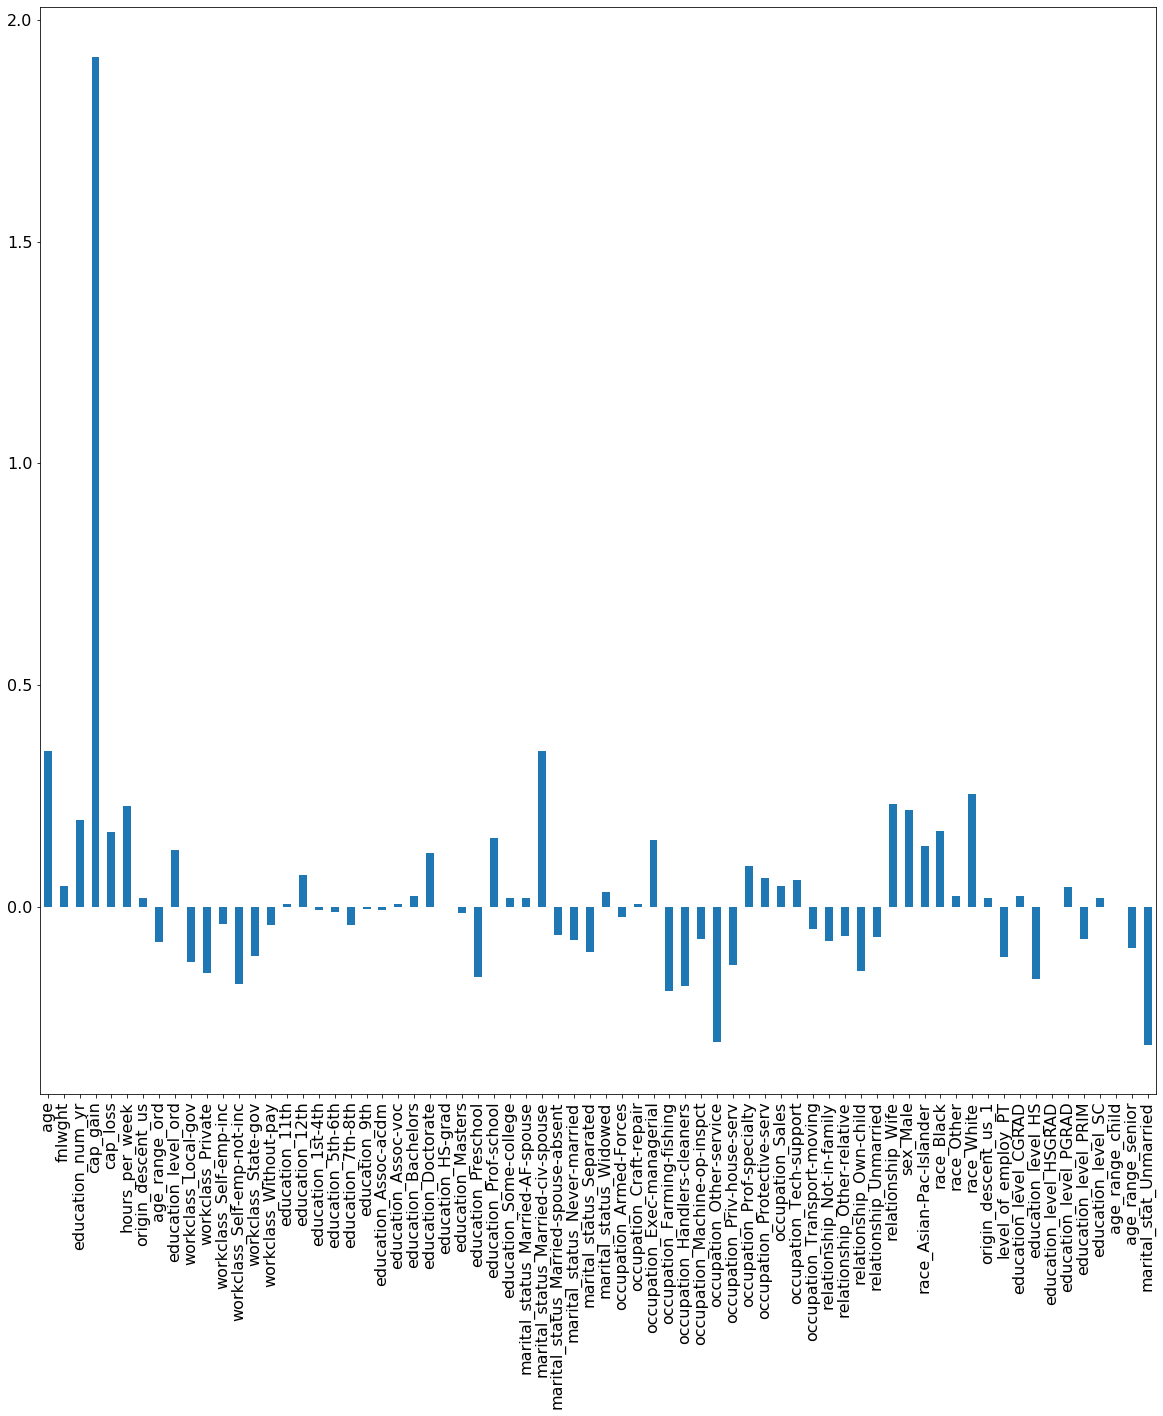

In [42]:
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=ml_df.columns)
weights.plot(kind='bar',figsize=(20,20), fontsize=16)

In [43]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4

df_tested_on = smote_df_.iloc[train_indices].copy() 
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['income_outcome'] = y_upsam_smote_[svm_clf.support_] 

df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14166 entries, 656 to 29620
Data columns (total 71 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   14166 non-null  float64
 1   fnlwght                               14166 non-null  float64
 2   education_num_yr                      14166 non-null  float64
 3   cap_gain                              14166 non-null  float64
 4   cap_loss                              14166 non-null  float64
 5   hours_per_week                        14166 non-null  float64
 6   origin_descent_us                     14166 non-null  float64
 7   age_range_ord                         14166 non-null  float64
 8   education_level_ord                   14166 non-null  float64
 9   workclass_Local-gov                   14166 non-null  float64
 10  workclass_Private                     14166 non-null  float64
 11  workclass_Sel

###### Support Vectors to analyze

<Figure size 720x288 with 0 Axes>

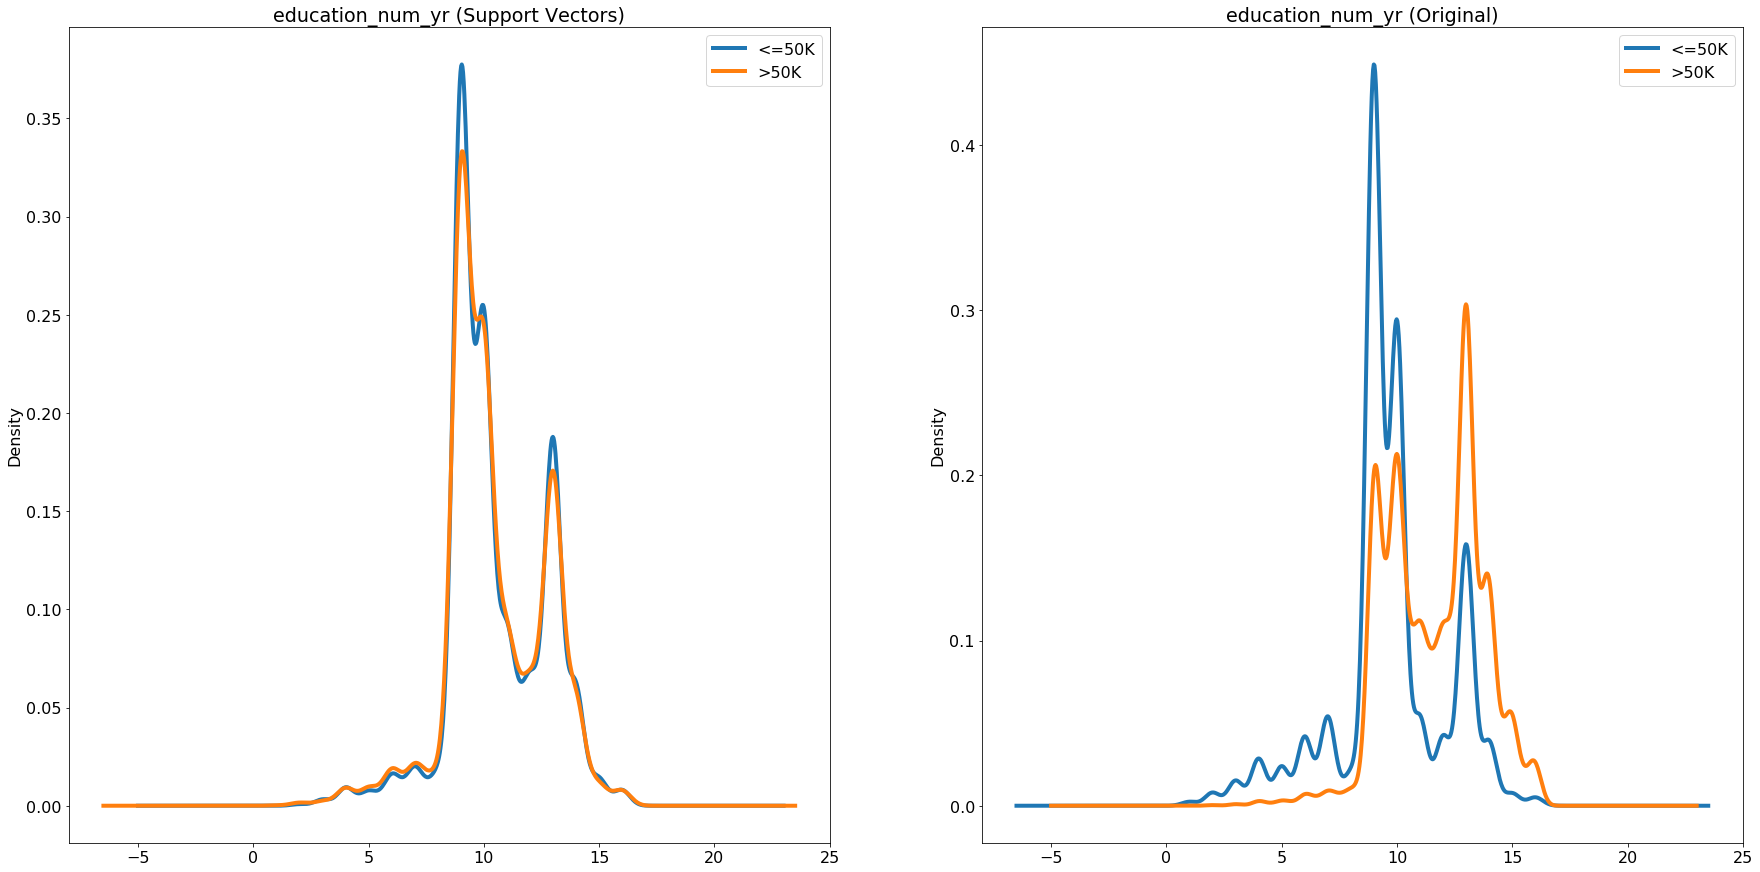

<Figure size 720x288 with 0 Axes>

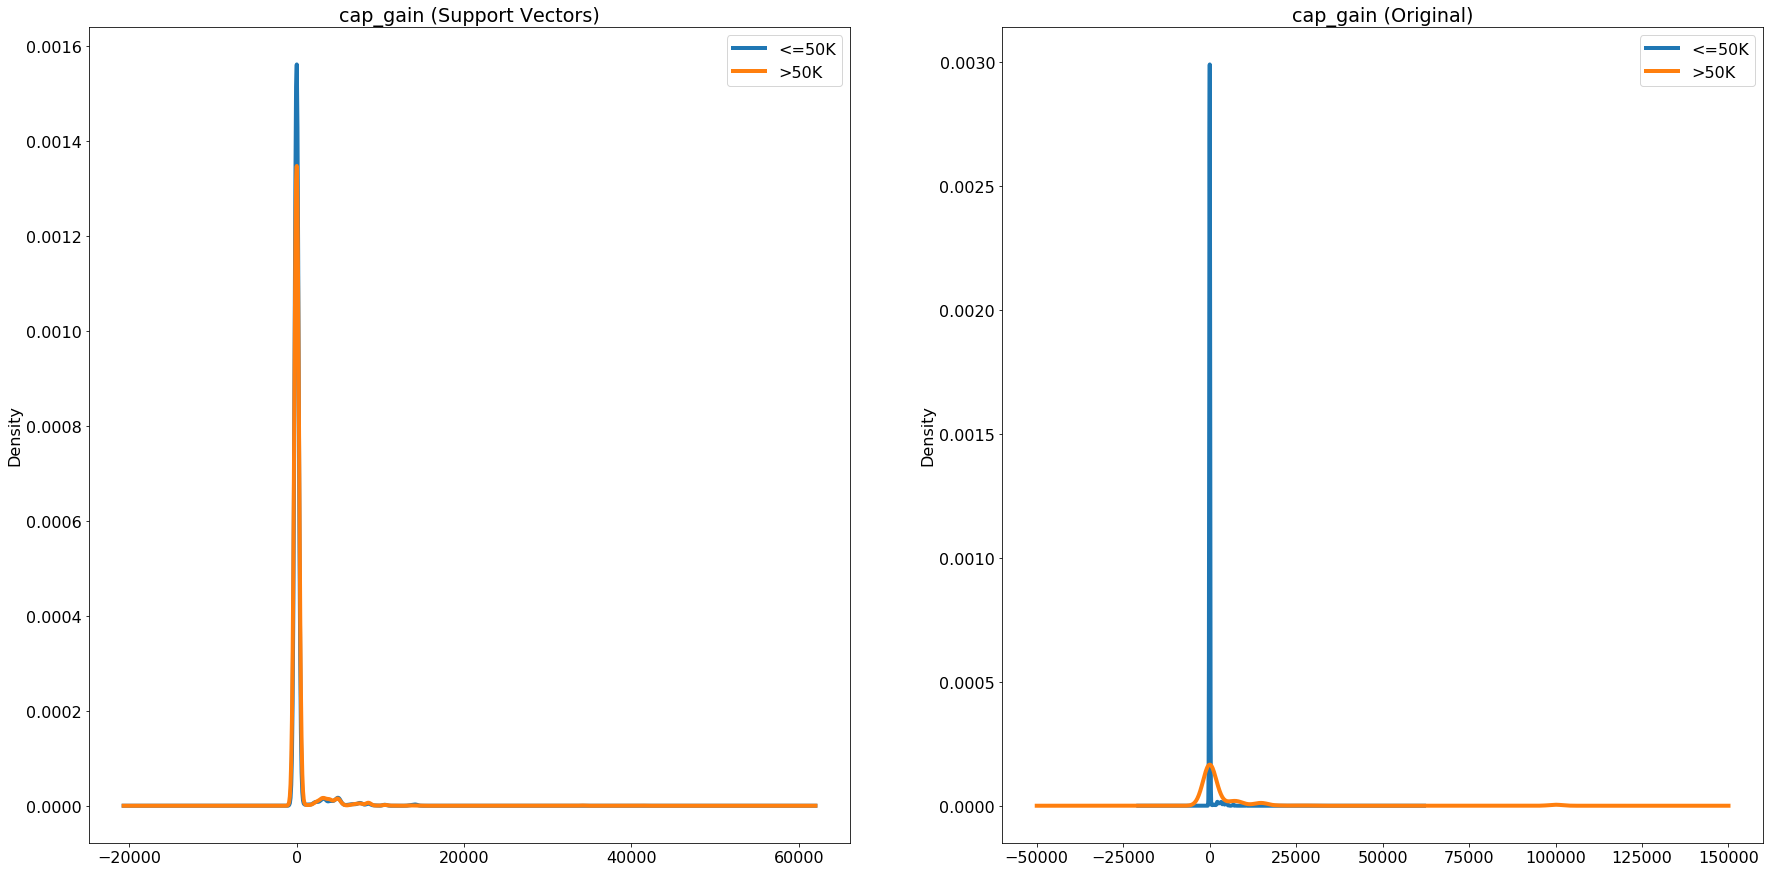

<Figure size 720x288 with 0 Axes>

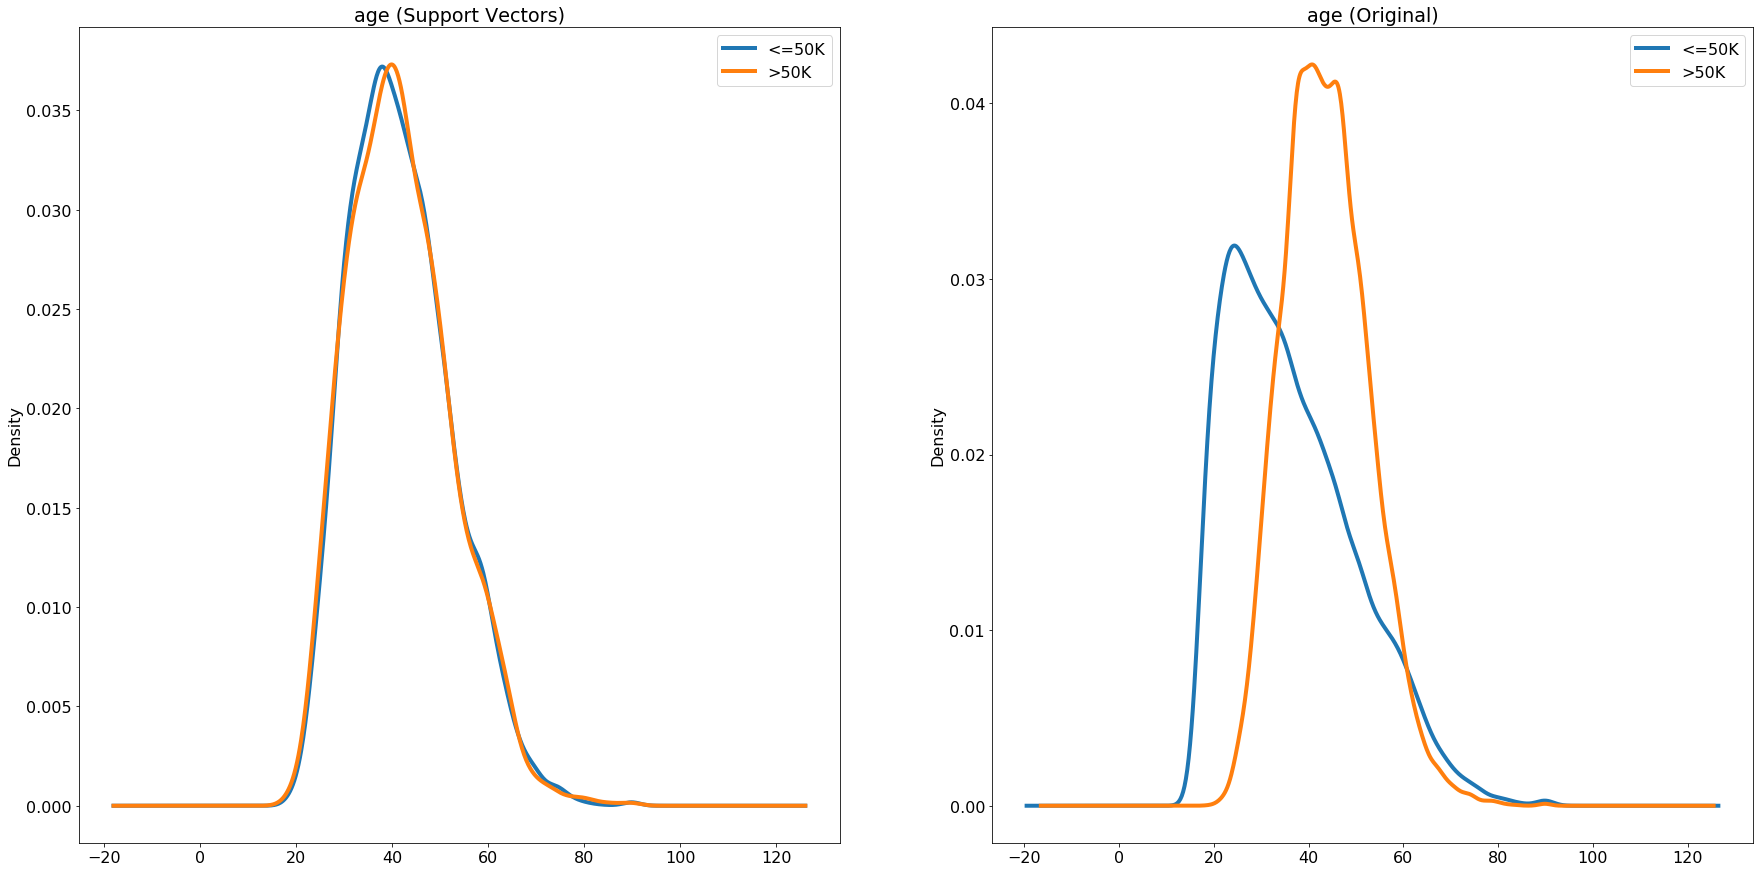

<Figure size 720x288 with 0 Axes>

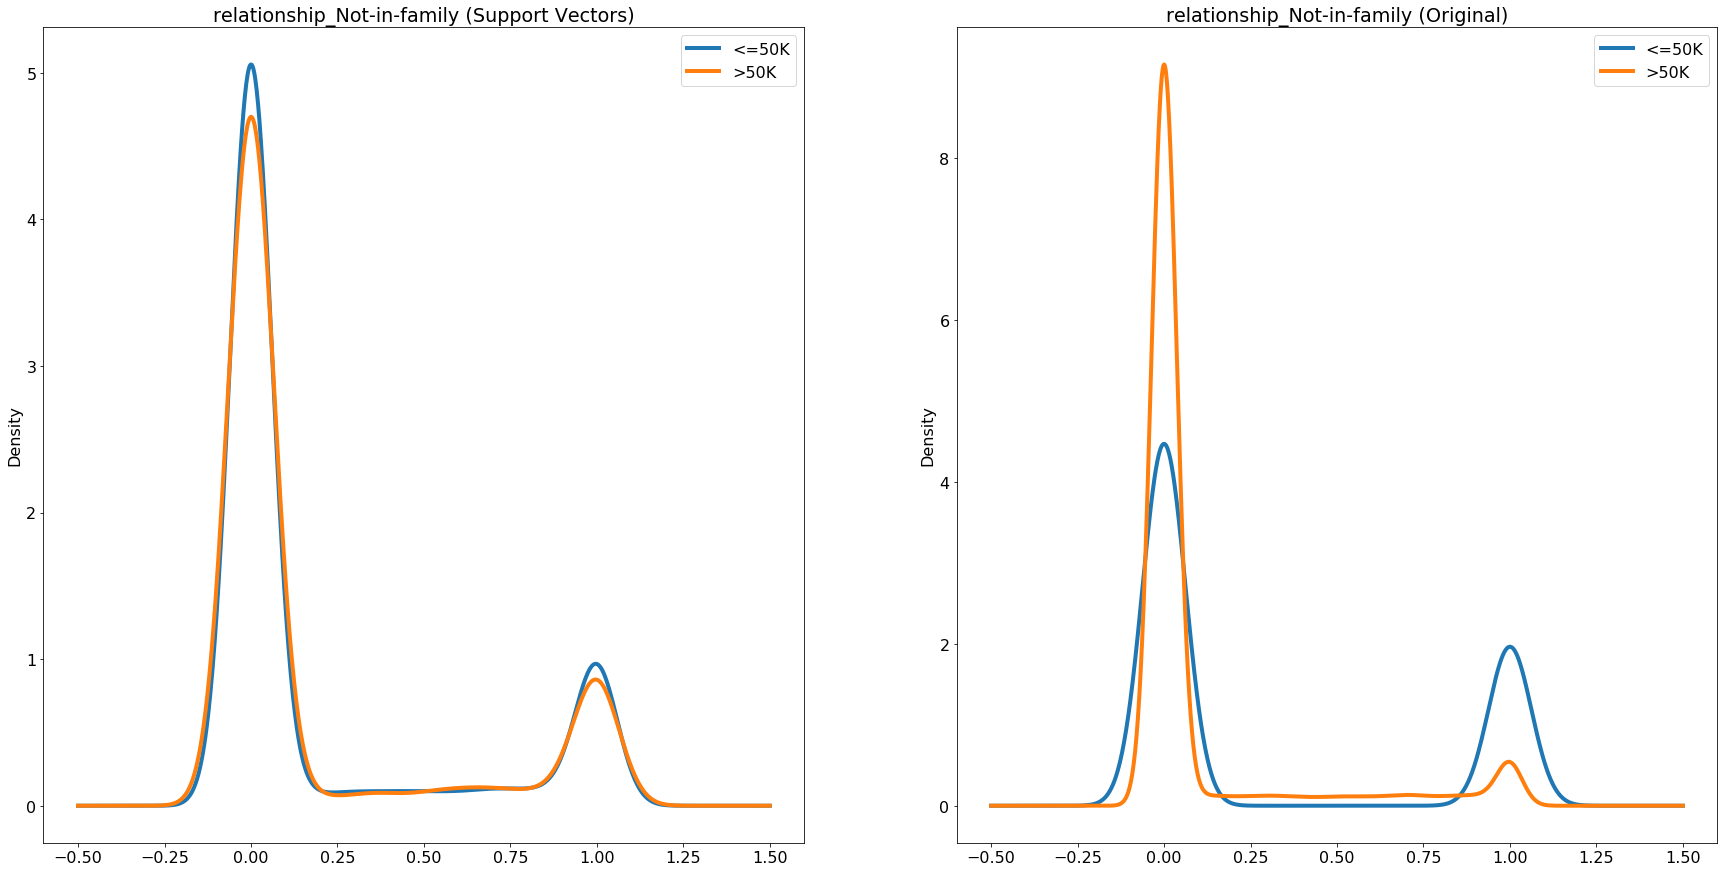

<Figure size 720x288 with 0 Axes>

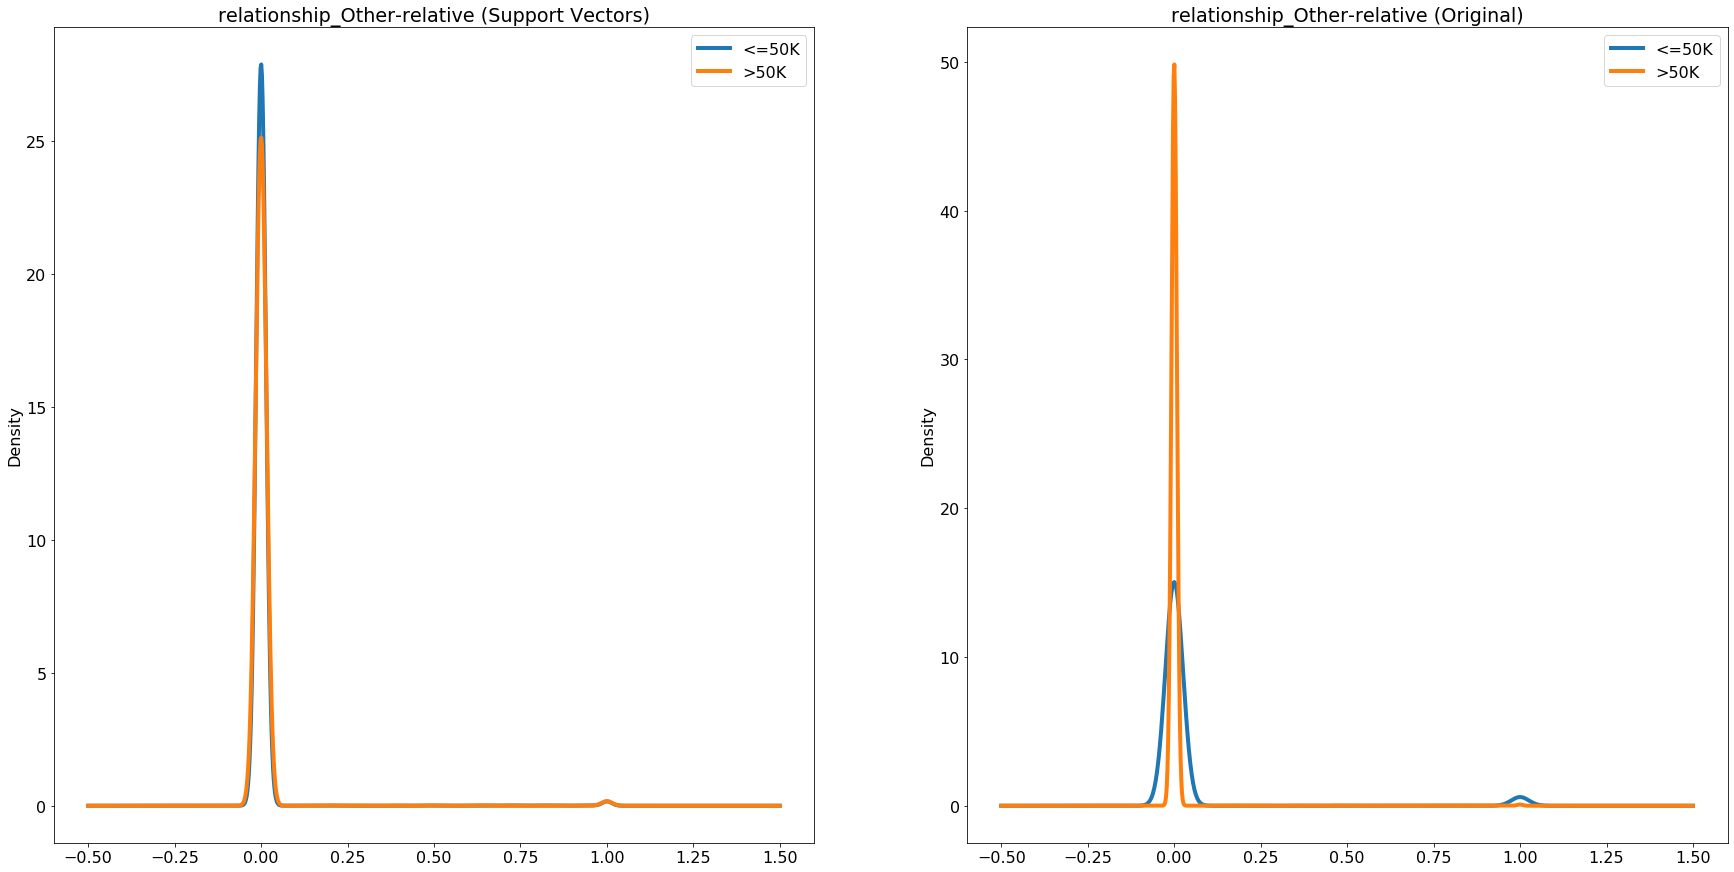

<Figure size 720x288 with 0 Axes>

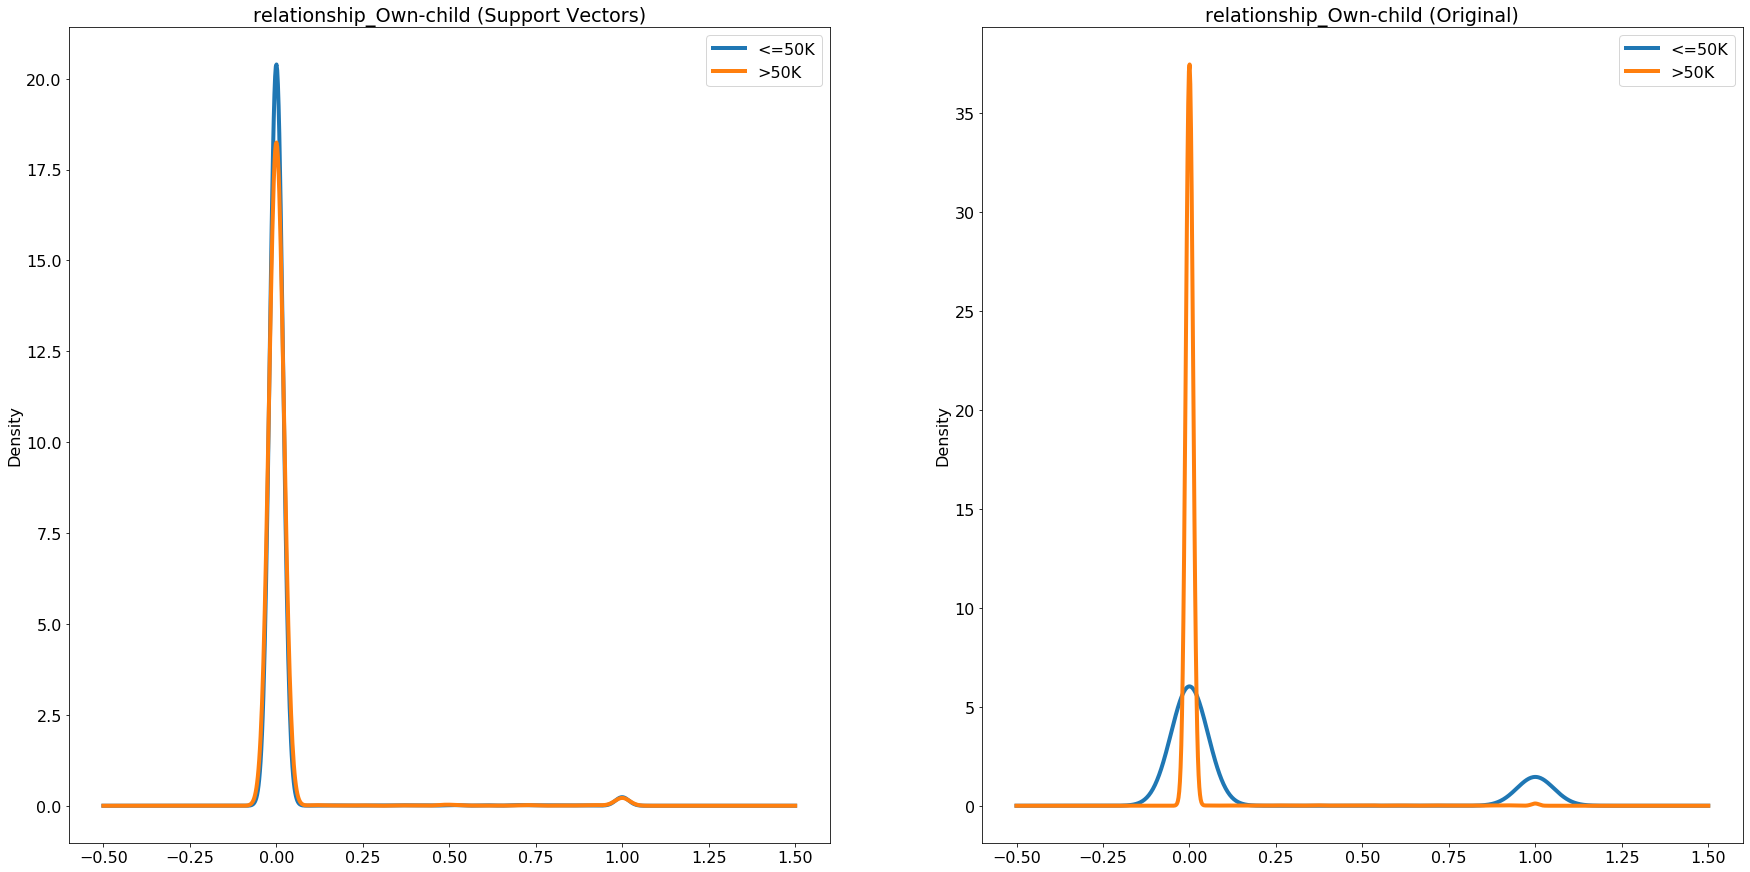

<Figure size 720x288 with 0 Axes>

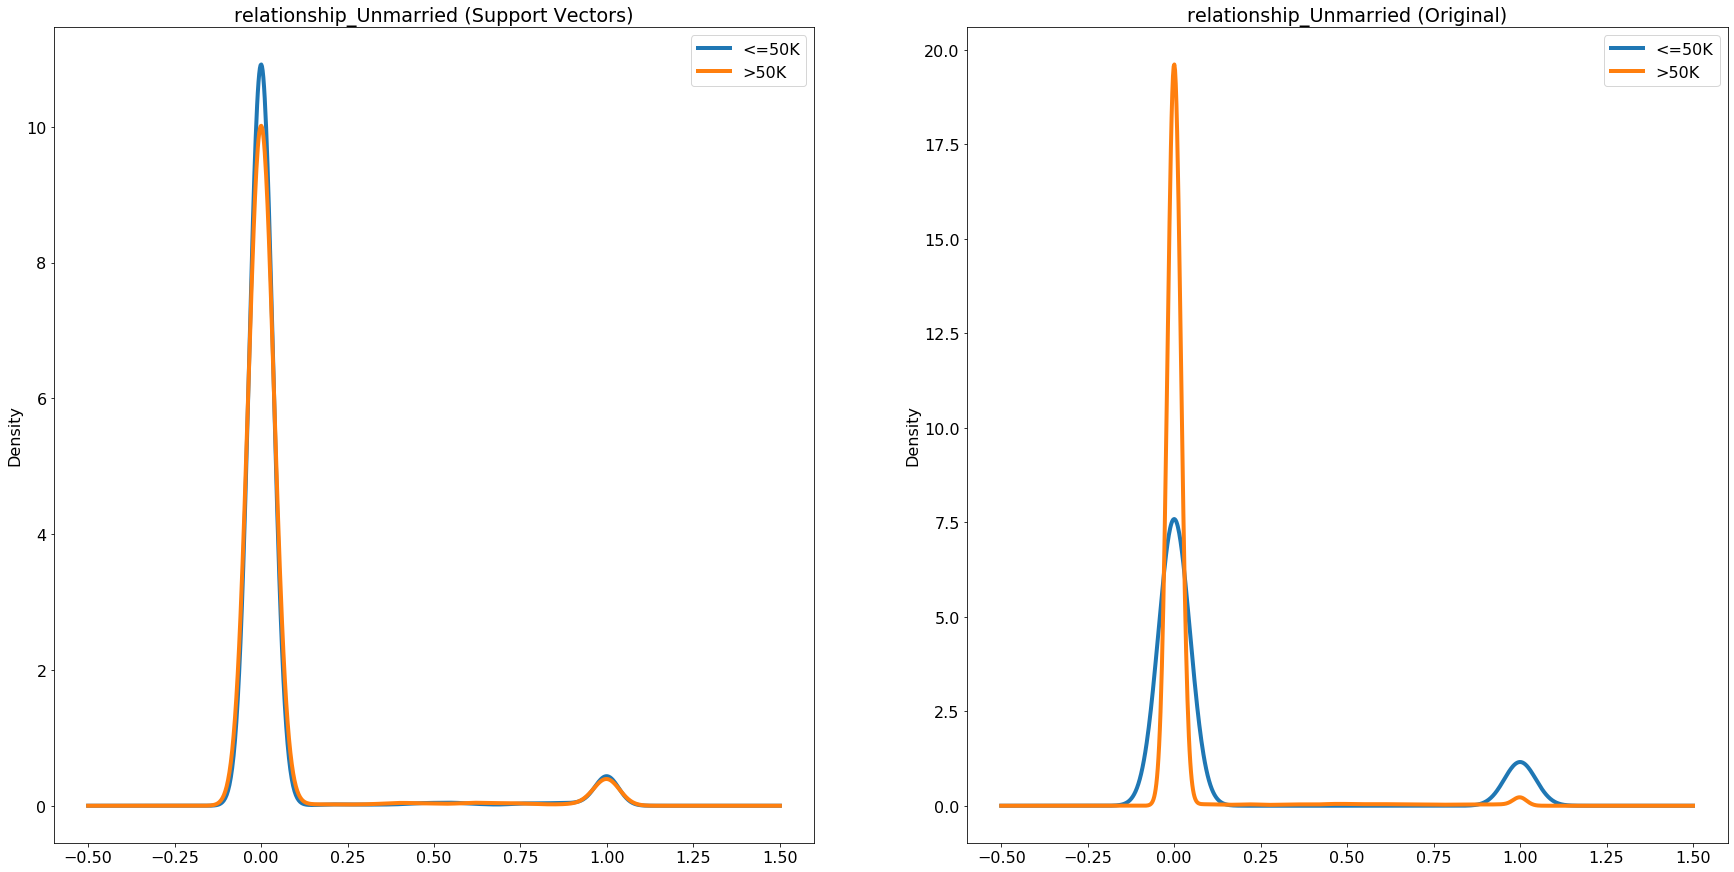

<Figure size 720x288 with 0 Axes>

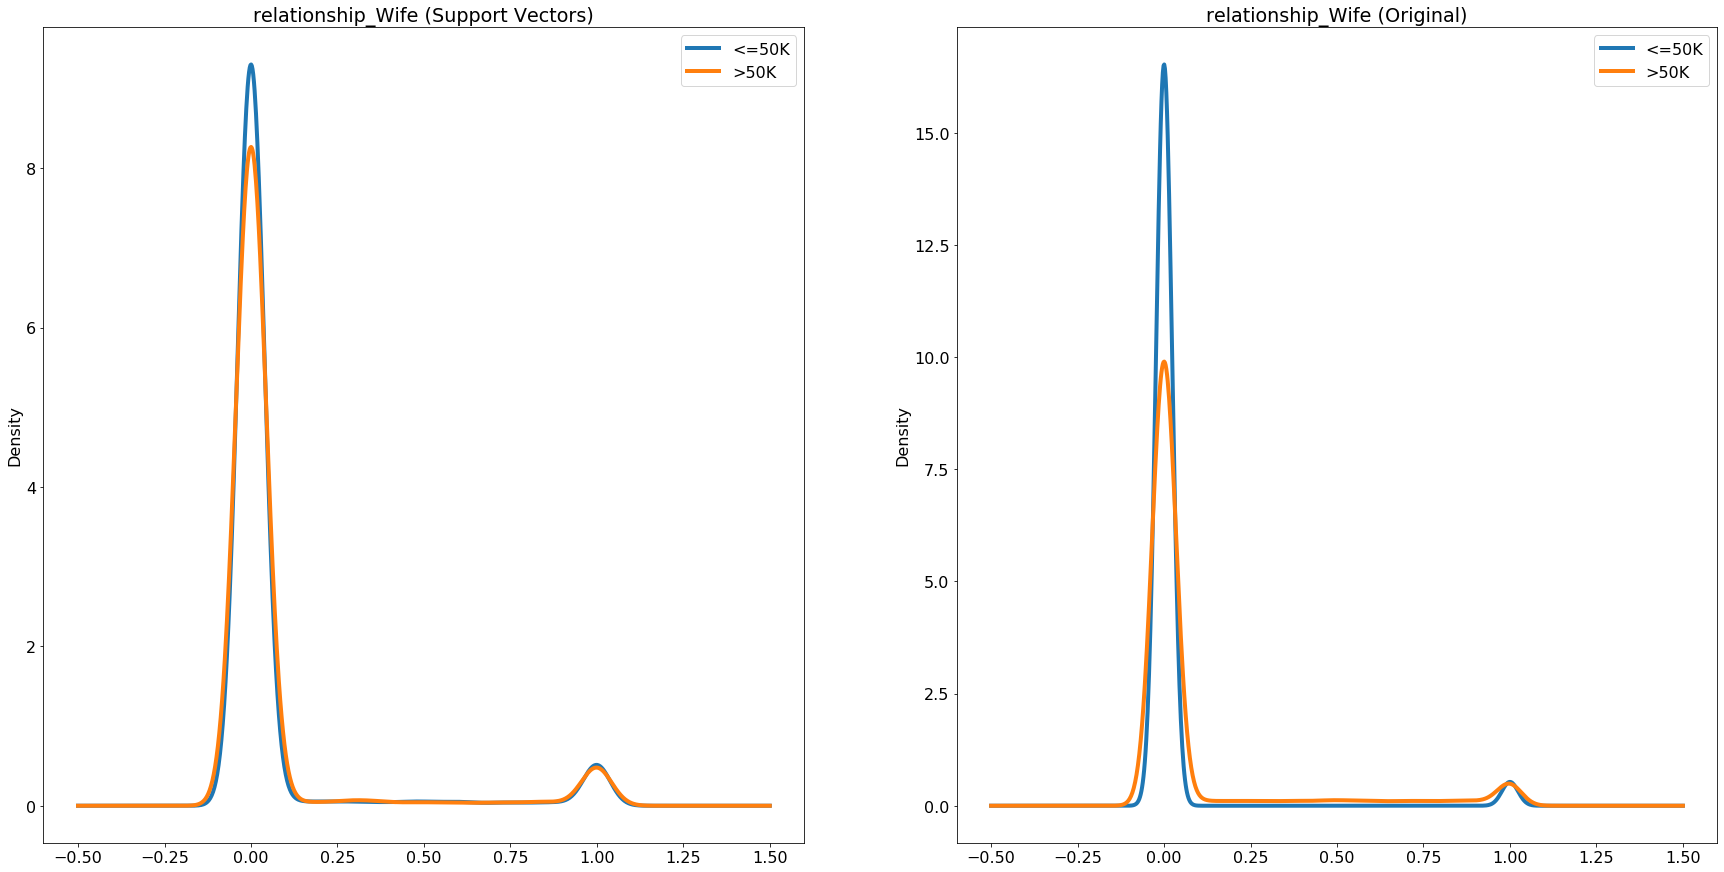

<Figure size 720x288 with 0 Axes>

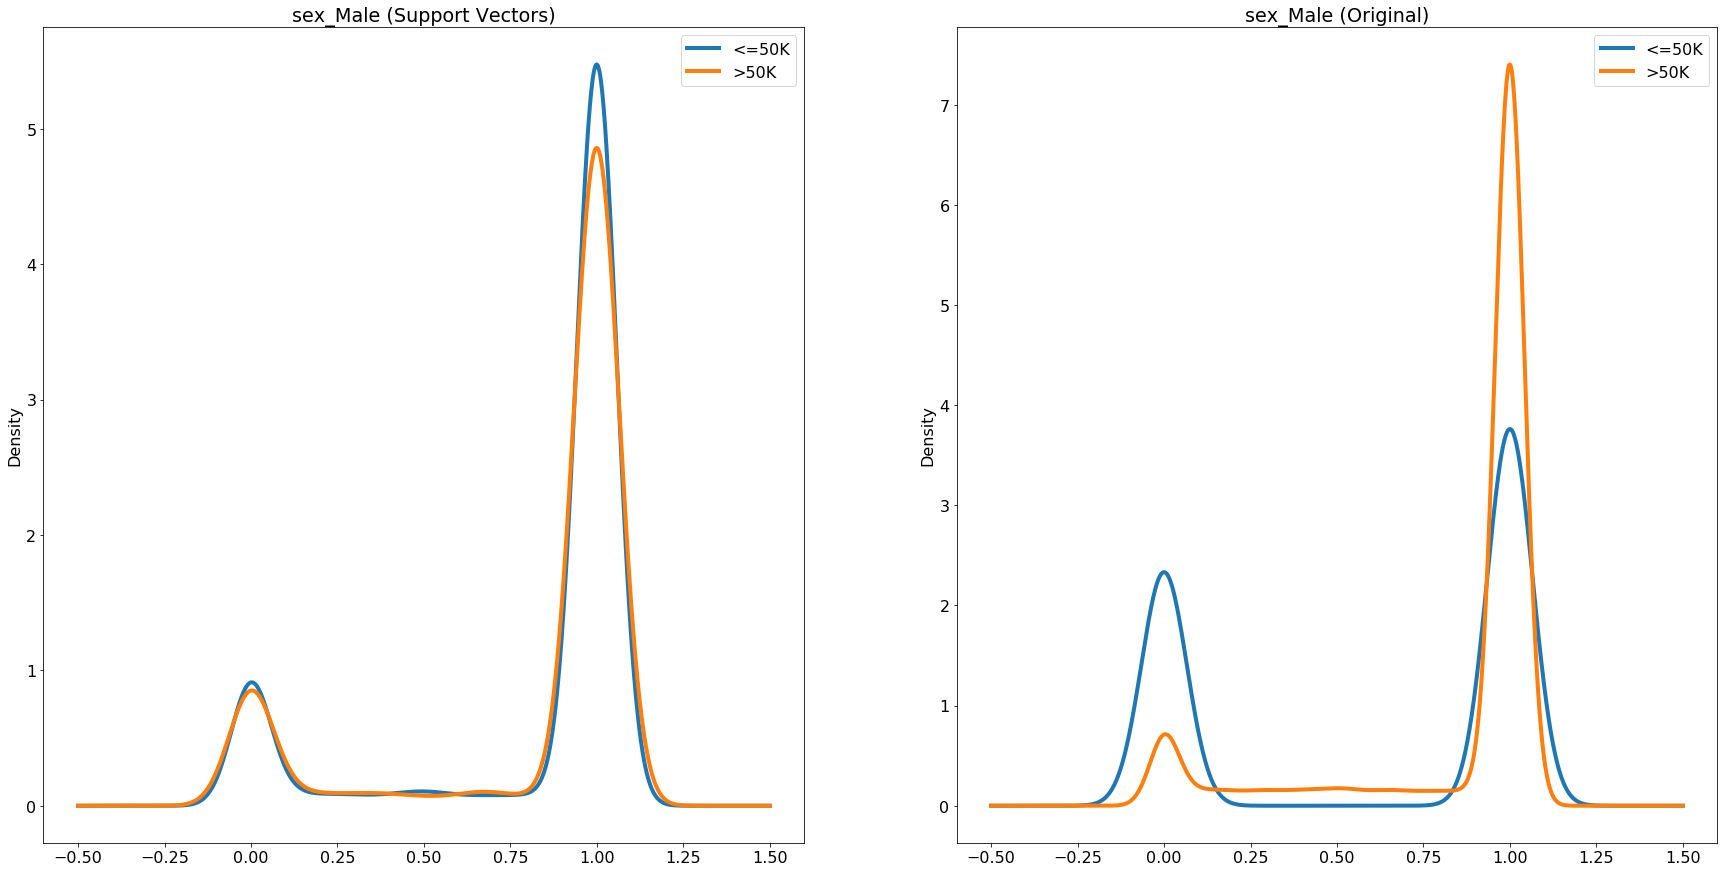

<Figure size 720x288 with 0 Axes>

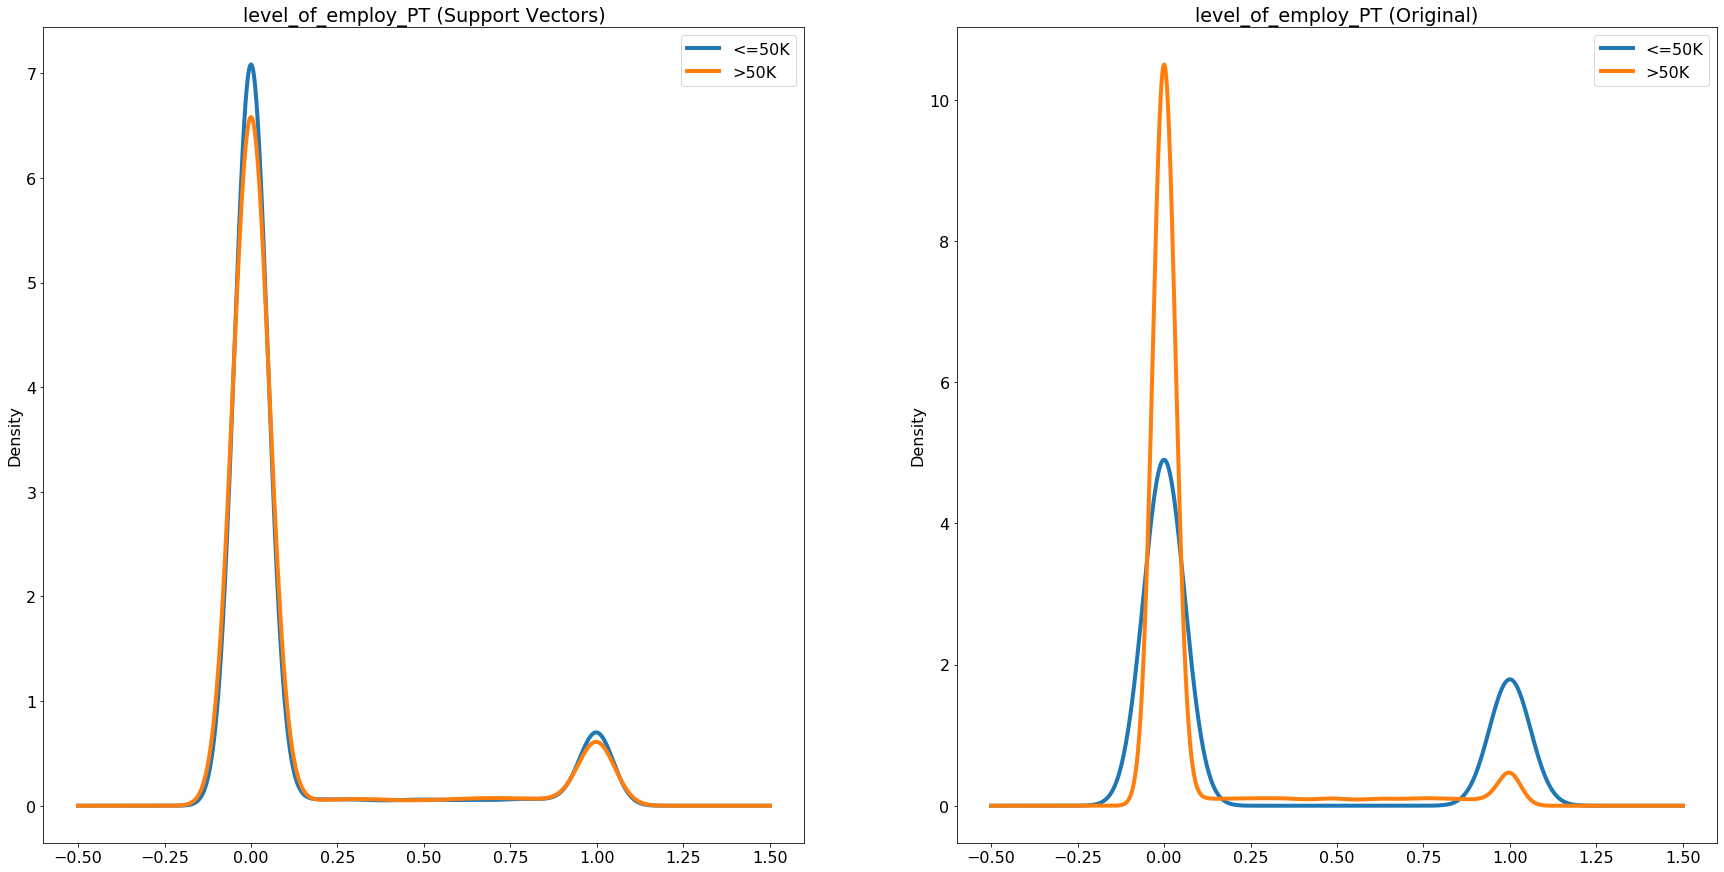

In [44]:
df_grouped_support = df_support.groupby(['income_outcome'])
df_grouped = smote_df_.groupby(['income_outcome'])

# plot KDE of Different variables
vars_to_plot = ['education_num_yr', 'cap_gain', 'age', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'sex_Male', 'level_of_employ_PT']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    plt.figure(figsize=(30,15))
    plt.rcParams.update({'font.size': 16,'lines.linewidth':4})
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Original)')

# 2) Model Advantages


When comparing our models for the task of predicting whether an individual makes more or less than $50,000, or main metric of success is accuracy.

However, in addition to accuracy, we will want to keep an eye on the AUC score to ensure our accuracy is robust by using the AUC score to view the probability that the model ranks an instance of >=$50,000 higher than an instance of <$50,000. 


The runtime of the models are also taken into account, but because this classifier will not need to be real-time, we can put less weight on this metric unless the time to run the model becomes prohibitively long (e.g. > one minute). As the intended business case use of this classifier is for accuracy purposes and potentially running on lean machine resources. 


Before we discuss any further, let's take a look at the comparison grids

In [45]:
#logistic Regression Summary Table
lr_summary

Model   Accuracy  AUC Score  Train Time
0          LR Full  84.610695  76.584047    1.799912
1       LR Reduced  83.402605  73.823963    0.357978
2         LR SMOTE  83.263228  83.263228    3.432886
3  LR Rduced SMOTE  75.761936  75.761936    0.391129

In [46]:
#SVM Summary Table
SVM_scores = {'Model' : ['SVC-rbf', 'SGDClassifier', 'SVC-Linear'], 'Accuracy' : [mean_accuracy_SVC_rbf_GA, accuracy_sdg_mean, accuracy_SVC_linear], 'AUC Score' : [mean_auc_SVC_rbf_GA, auc_sdg_mean, auc_SVC_linear],'Train Time' : [mean_runtime_SVC_rbf_GA, runtime_sdg_mean, runtime_SVC_linear]}

SVM_summary = pd.DataFrame(data=SVM_scores)
SVM_summary

Model              Accuracy             AUC Score  \
0        SVC-rbf                 87.44                 87.44   
1  SGDClassifier               83.0308               83.0308   
2     SVC-Linear  [0.8306398051804295]  [0.8306398051804296]   

             Train Time  
0               103.557  
1              0.460227  
2  [166.34952676599994]

##### Model Summary
As we can see form the results, the best performing logistic regression model is the SMOTE model, with a mean accuracy of 83.59%, a mean AUC score of 83.59%, and a mean train time of 3.91 seconds.  While the accuracy of the SMOTE model is about one percent less (83.59 vs 84.61) than the full model, the AUC score is increased from 76.57% to 83.59% with not a large increase to runtime  (3.91 seconds [SMOTE] vs 1.70 seconds [full]).  The runtime for the reduced and reduced SMOTE models is about one tenth of the time, but the increase in both accuracy and AUC scores warrant selecting the SMOTE model as the preferable logistic regression model. It should be noted that the LR SMOTE model is upsampled, making it susceptible to overfitting to new unseen data. 

Comparing the Support Vector Machines (SVM) models, runtime becomes more important as the number of attributes drastically increases the calculation time.  Using SVC with an rbf kernel, we obtain better accuracy and AUC than all of the logistic regression models, but the runtime is between 99 and 108 seconds.  While our classifier need not be real-time, waiting a minute and a half for results is inefficient for a four percent increase in accuracy and AUC.  

Using SGD Classifier combined with a grid search to tune the parameters and SMOTE up sampling, we observe similar metrics to our SMOTE logistic regression model. The mean accuracy is 83.60%, AUC score of 83.60%, and a mean runtime of 0.46 seconds.  

Using a linear SVC and a subsampled population, we were able to achieve an accuracy of 83.92%, an AUC score of 83.92%, and a train time of 174.746 seconds.  The train time for this model was significantly longer than the rbf kernel, and would be prohibitively long if we were to use the entire data set.  For the reasons stated, we only ran one iteration in order to obtain the support vectors for analysis.  


##### Accuracy
In terms of overall accuracy, the SVC-rbf model performed the best with a mean accuracy of 87.62%, over three percent higher than the LR Full model which came in second with 84.61%.  The SVC-rbf model also had the highest AUC score with 87.62% which bested the LR SMOTE model (83.59) by over four percent.  With the Train Time at 107.46 seconds, it is the second slowest model, but wins in the case where accuracy is key and time is not a factor.  

##### Train Time
If train time became a significant factor in the business use case of the model, the SDGClassifier model had the fastes Train Time while still scoring 83.23% for both accuracy and AUC Score.  While the SDGClassifier is only the fifth best performing in terms of accuracy, it ranks in foruth when it comes to AUC Score.  Therefore, when time is of the essence, the SdGClassifier can perform quickly while maintianing high accruacy and AUC scores.  

# 3) Interpret Feature Importance

In [47]:
#### WEIGHT GRAPH FOR LR Smote MODEL
error_y=dict(
            type='data',
            array=np.std(weights_smote,axis=0),
            visible=True
        )

graph1 = {'x': ml_df.columns,
          'y': np.mean(weights_smote,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars (LR SMOTE Model)', 'height': 1000, 'width': 1400, 'font': {'size':14}}
plotly.offline.iplot(fig)

--Capital gain

In reviewing the cap gain KDE from the section above, we see there is a hard distintion to see between the incomes >50K and <= 50K. However, looking at the outcome of more than 7.5K in capital gains, we can see that we have almost esclusively >50k for the "yes" values, however we are still left dealing with the majority of >50k values in the "no" bin. This could still be beneficial for our classifier, as anyone with capitla gains over 7000 would have a very good chance of being classified correctly, and it makes sense why the logistic regression model is weighting this feature heavily. 

Practically, it would stand to reason that those who make more money have more money to invest, and therefore are seeing some sort of capital gains or losses. We will attempt to see if we can tease out some of those >50k values by binning capital gain values. Let's see whether or not those with higher capital gains tend to make over 50k.

Looking at this, we do see there is an association with larger capital gains and making more than 50K.



In [48]:

#Separating by capital gains
ml_data_copy["bigcap"]=np.where(ml_data_copy["cap_gain"]>7500,"yes","no")

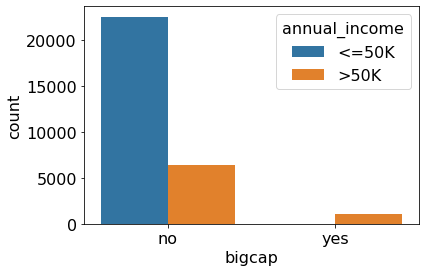

In [49]:

#bigcap broken out by annual_income
sns.countplot(x="bigcap", hue="annual_income", data=ml_data_copy)

--Marital Status

Marital status seems to be an extremely significant indicator of achieving an income over 50k. The proportion of Married-civ-spouse making over 50k is extremely high compared to the others. This makes sense as to why the logistic regression model weighted Married-civ-spouse higher than the other nominal values within the married feature. We can clearly see, the odds of making more than 50K is increased for those who are married-civ-spouse. 

[Text(0, 0, 'Never-married'),
 Text(0, 0, 'Married-civ-spouse'),
 Text(0, 0, 'Divorced'),
 Text(0, 0, 'Married-spouse-absent'),
 Text(0, 0, 'Separated'),
 Text(0, 0, 'Married-AF-spouse'),
 Text(0, 0, 'Widowed')]

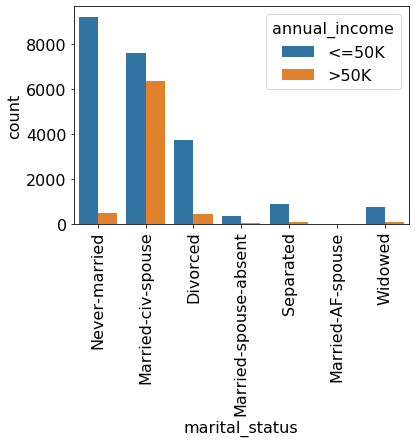

In [50]:
#martial_status broken out by annual_income
chart=sns.countplot(x="marital_status", hue="annual_income", data=ml_data_copy)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

--Age

Looking at the KDE plot of the continous value for age for the original data, we see there is a clear shift in the income outcome response. In general, there appears to be an association with age and making over 50K. As one's mean age increases, so does their likelihood of earning more than 50K. And we see from below, as the mean age lessens so does their likelihood of making more than 50K. This also makes sense why the logistic regression model weighted this particular variable more favorable to the predicted outcome of greater than 50K. 

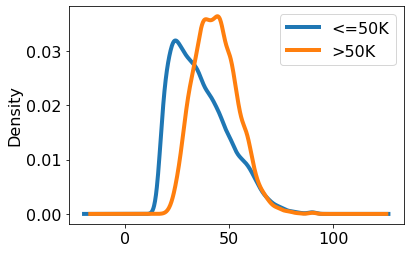

In [51]:
ax = ml_data_copy.groupby(['income_outcome']).age.plot.kde(legend=True) 
plt.legend(['<=50K', '>50K'])
plt.show()


--Sex

As we look at sex broken out by annual_income, it appears visually evident that a greater proportion of males make >$50k than do females. This is an important relationship to keep in mind as we continue building our classifier. We see from here, the odds of making more than 50K are greately improved if one is a male, and it stands to reason why the logistic regression model weighted this variable positvely. 

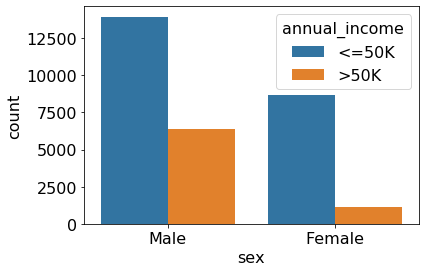

In [52]:
#Age broken out by annual_income
sns.countplot(x="sex", hue="annual_income", data=ml_data_copy)

With the SMOTE model being the best performing logistic regression model, we will look into the weights derived from that model.  However, because there are 70 attributes, we will examine in detail the five attributes with the highest absolute weight value.

-cap_gain 

cap_gain has a weight of 3.00.  Because cap_gain is a continuous attribute, we can interpret the weight as a one unit increase of cap_gain will increase the odds of a given individual making over 50,000 by a factor of 20. This attribute is crucial to our model as no other attribute weights even approached the value of one. We can say there appears to be a positive association with an increase in cap_gain and the odds of making over 50K. 

Applying common sense, it would follow that those with greater capital gains have a greater chance of making over 50,000 per year, as you need money to invest in order to have any capital gains. Those who make less than 50,000 likely allocate their income to essential costs such as housing, food, clothing, and transportation.

-marital_status_Married-civ-spouse 

marital_status_Married-civ-spouse has a weight of 0.55. marital_status is a categorical attribute, therefore we can interpret the weight as a change from the reference value of marital_status_Divorced to marital_status_Married-civ-spouse increases the odds of the individual making over $50,000 per year by 73%, or a multiplicative factor of 1.73.

-age 

age has a weight of 0.52.  Again we have a continuous variable, so we can interpret this as a one unit increase in age increases the odds of making over $50,000 by a multiplicative factor of 1.68 (a 68% greater chance). This conclusion also passes the common sense test as there certainly appears to be a positive association of an increase with age, increases the odds of increased income.     

-marital_stat_Unmarried 

marital_status_Unmarried has a weight of -0.49.  Again we have marital_status, which is a categorical attribute, therefore we can interpret the weight as a change from the reference value of marital_stat_Married to marital_status_Unmarried decreases the odds of the individual making over $50,000 per year by 39%, or a multiplicative factor of 0.61.  

-sex_Male 

sex_Male has a weight of 0.39.  here we have a binary variable, so we can interpret the weight of sex_Male as changing from a 0 (female) to a 1 (male) increases the odds of the individual making over $50,000 by 48%, or a multiplicative factor of 1.48.  


# 4) Interpret Support Vectors

<Figure size 720x288 with 0 Axes>

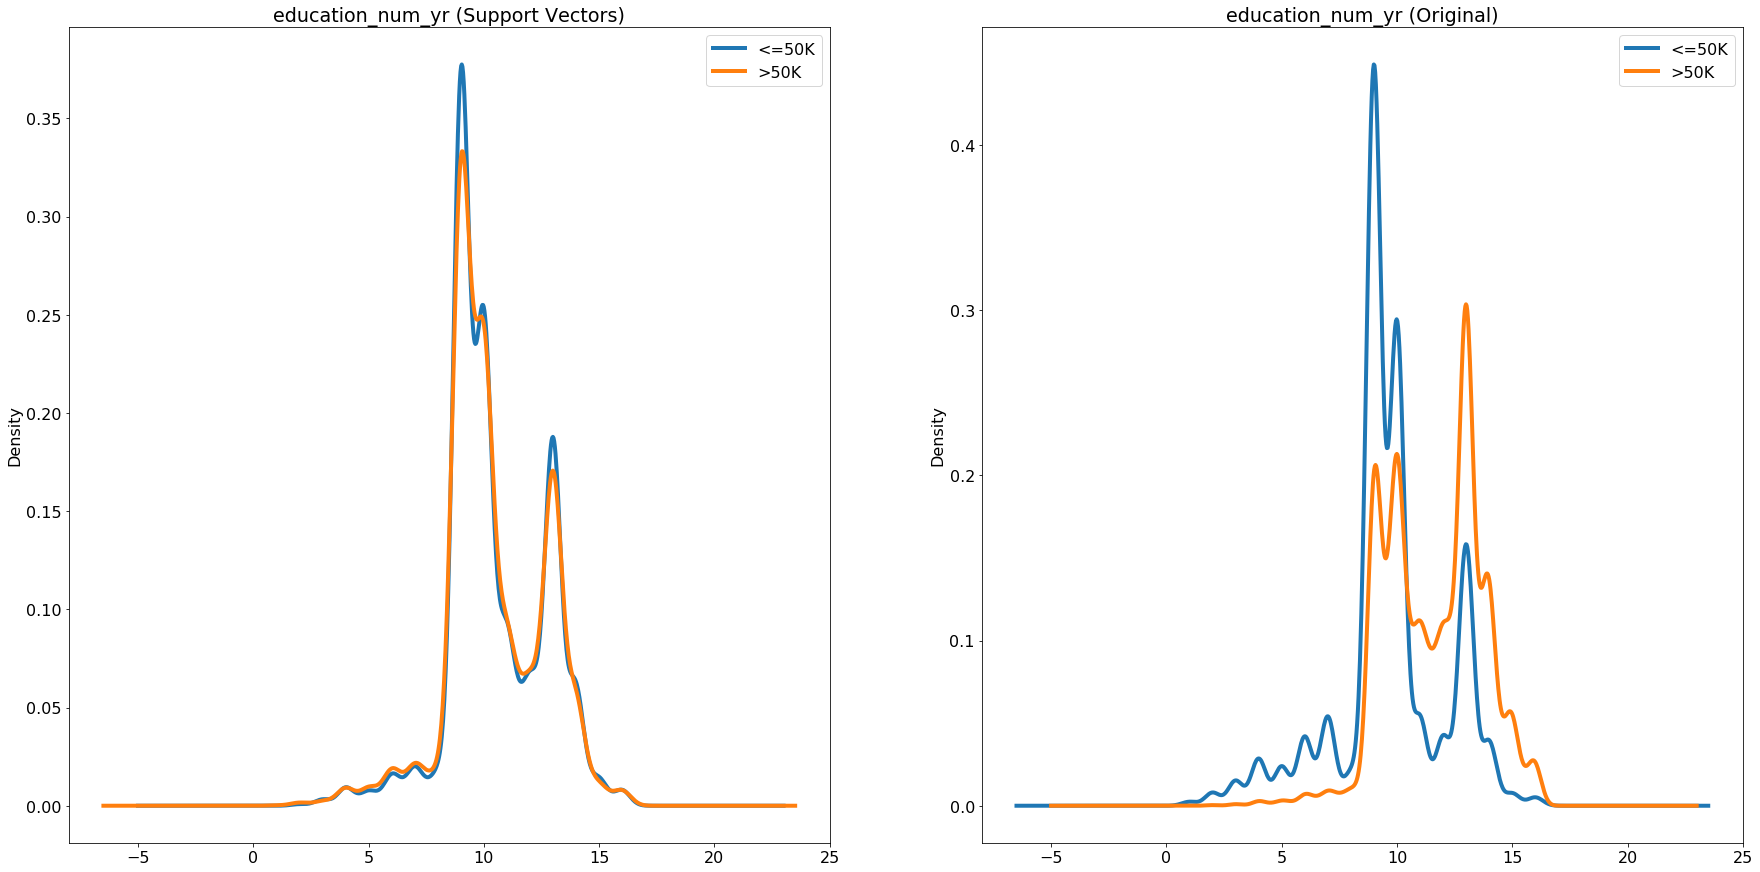

<Figure size 720x288 with 0 Axes>

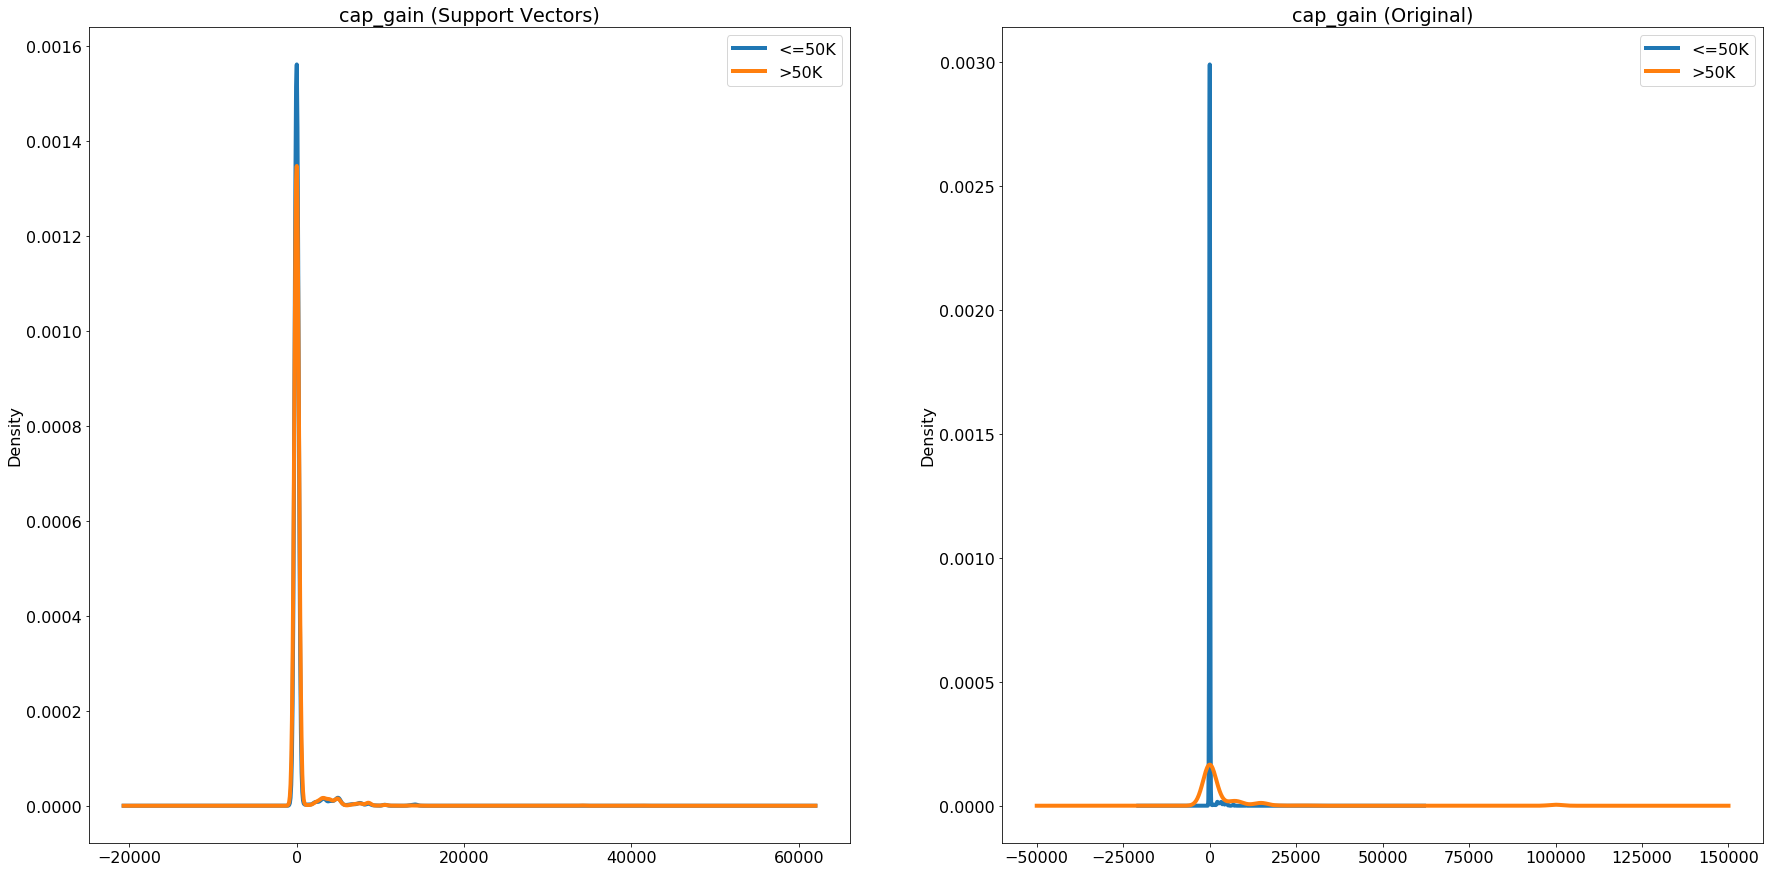

<Figure size 720x288 with 0 Axes>

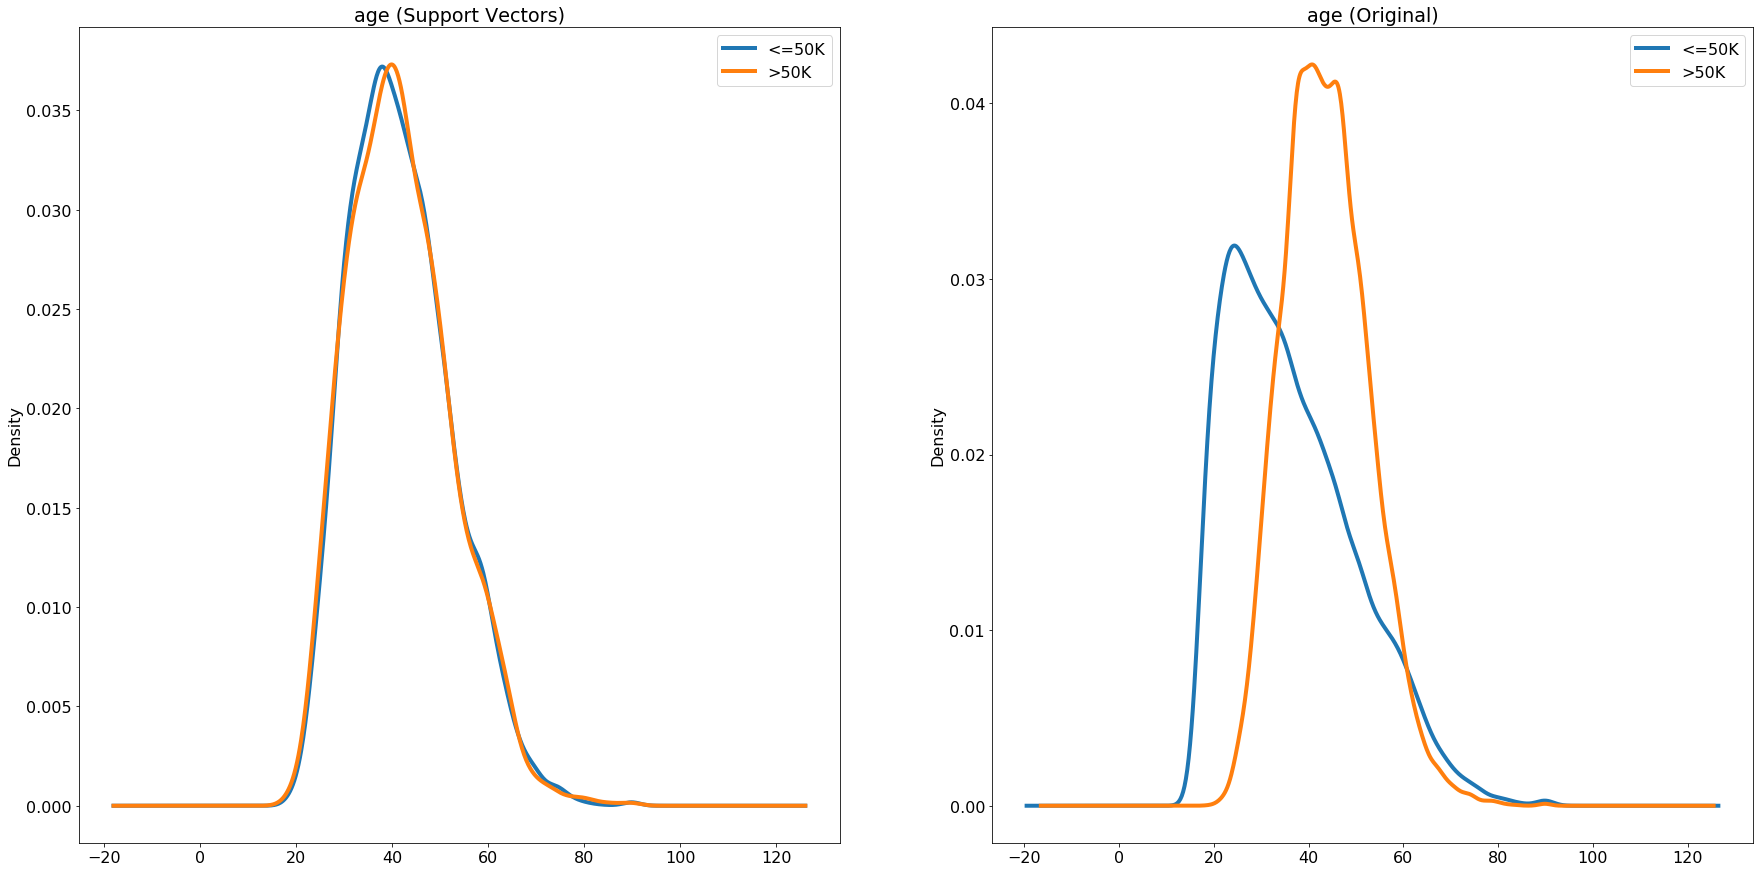

<Figure size 720x288 with 0 Axes>

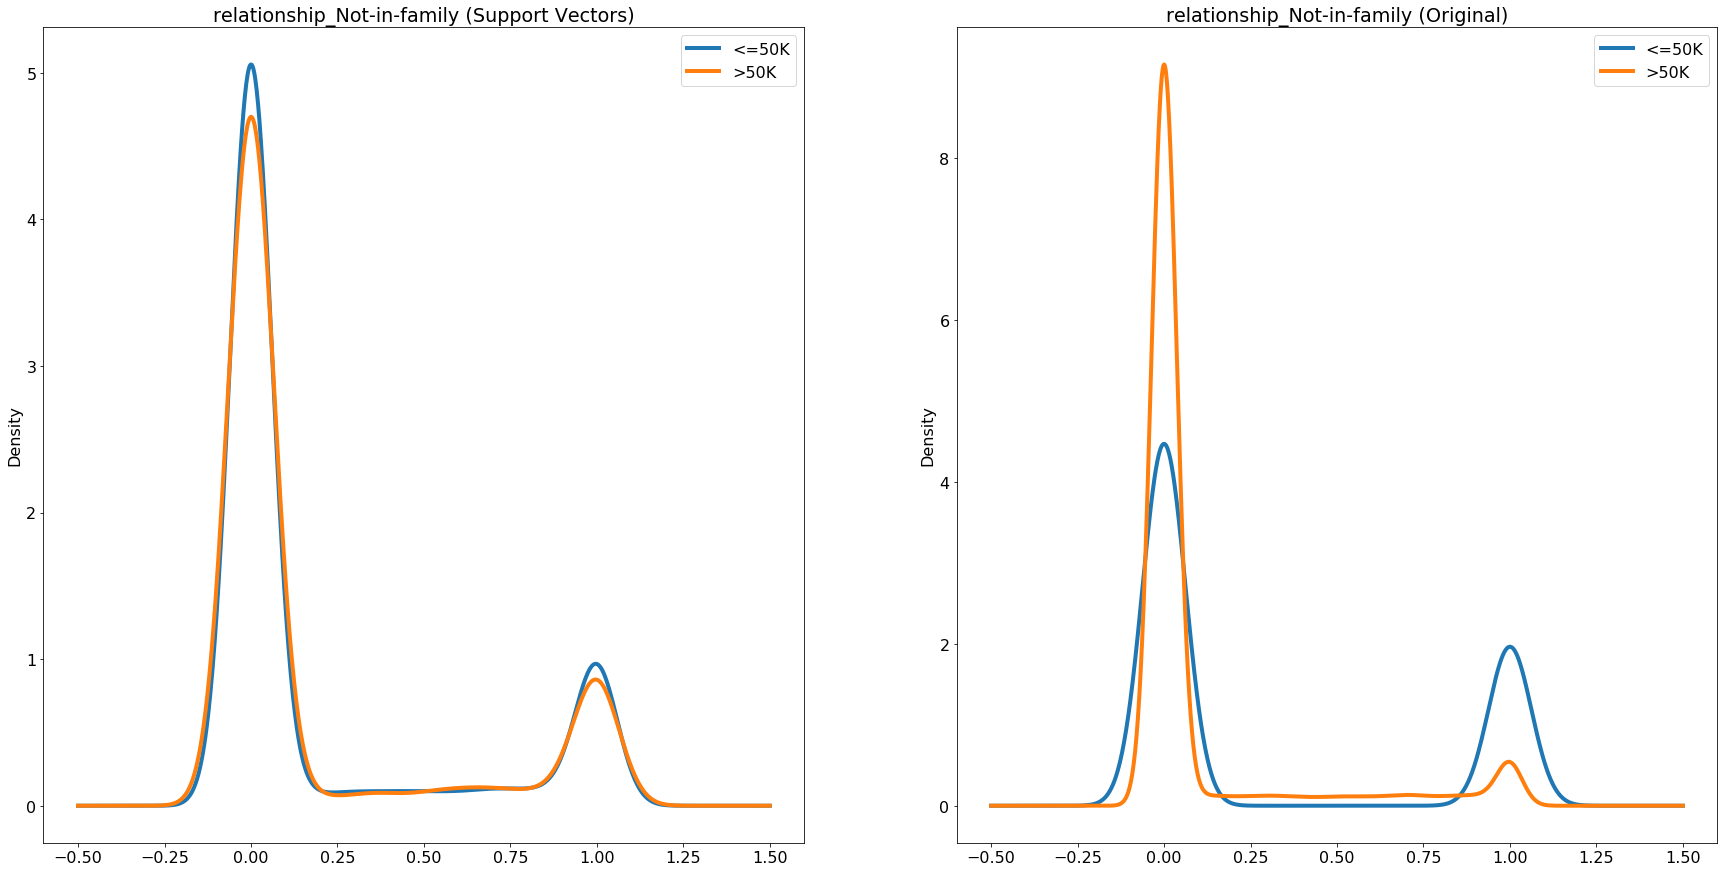

<Figure size 720x288 with 0 Axes>

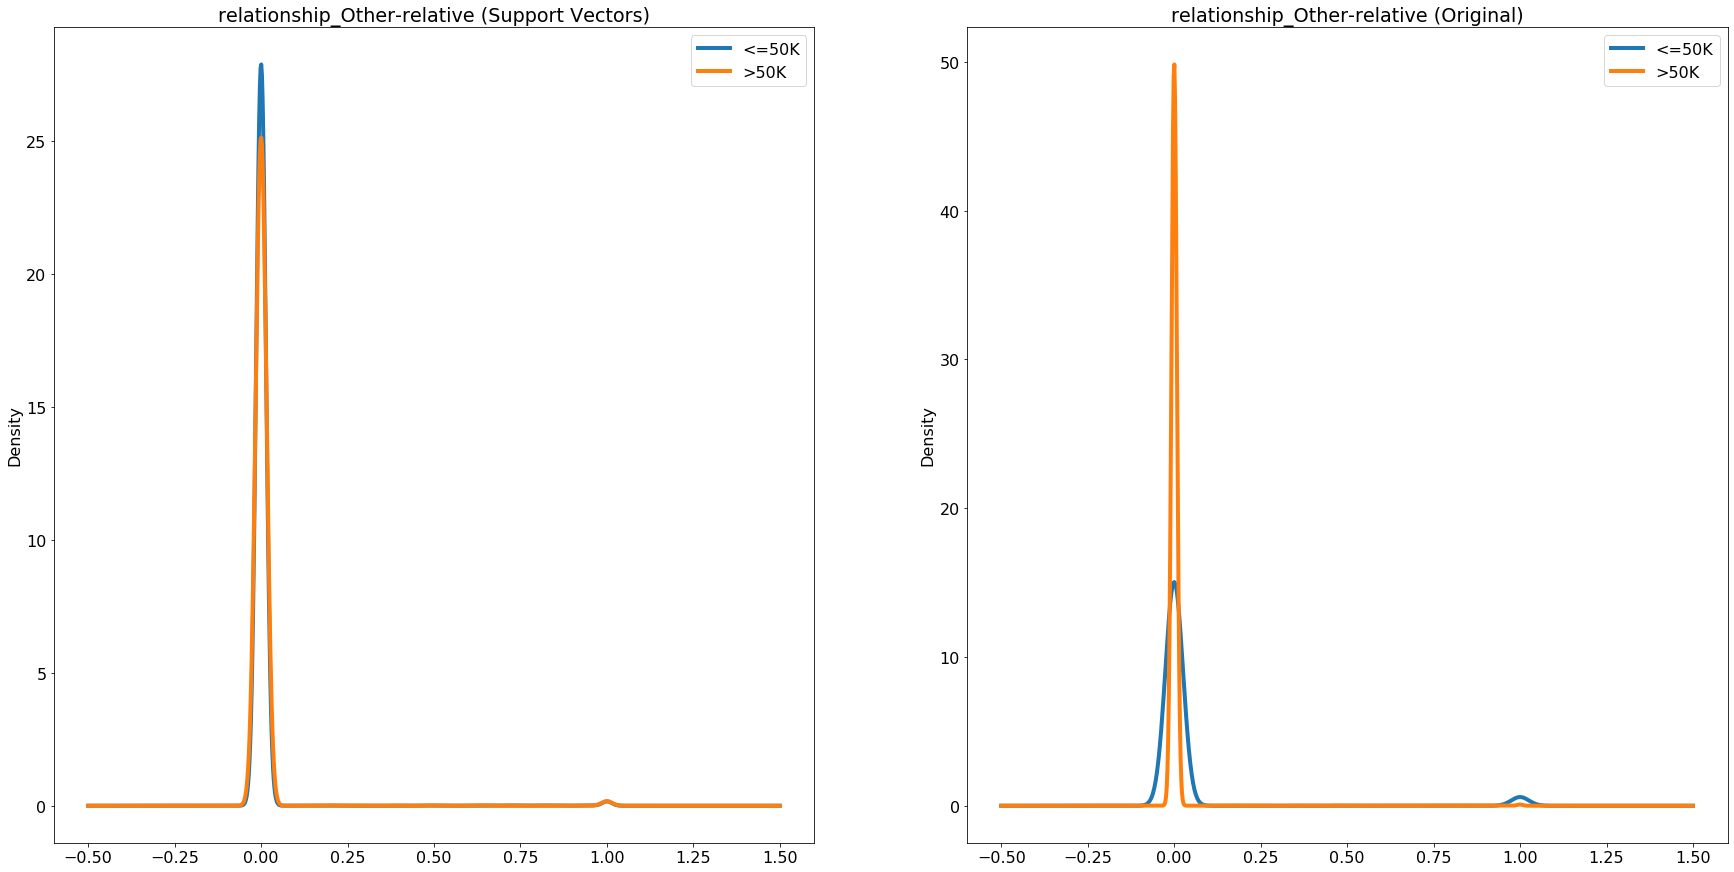

<Figure size 720x288 with 0 Axes>

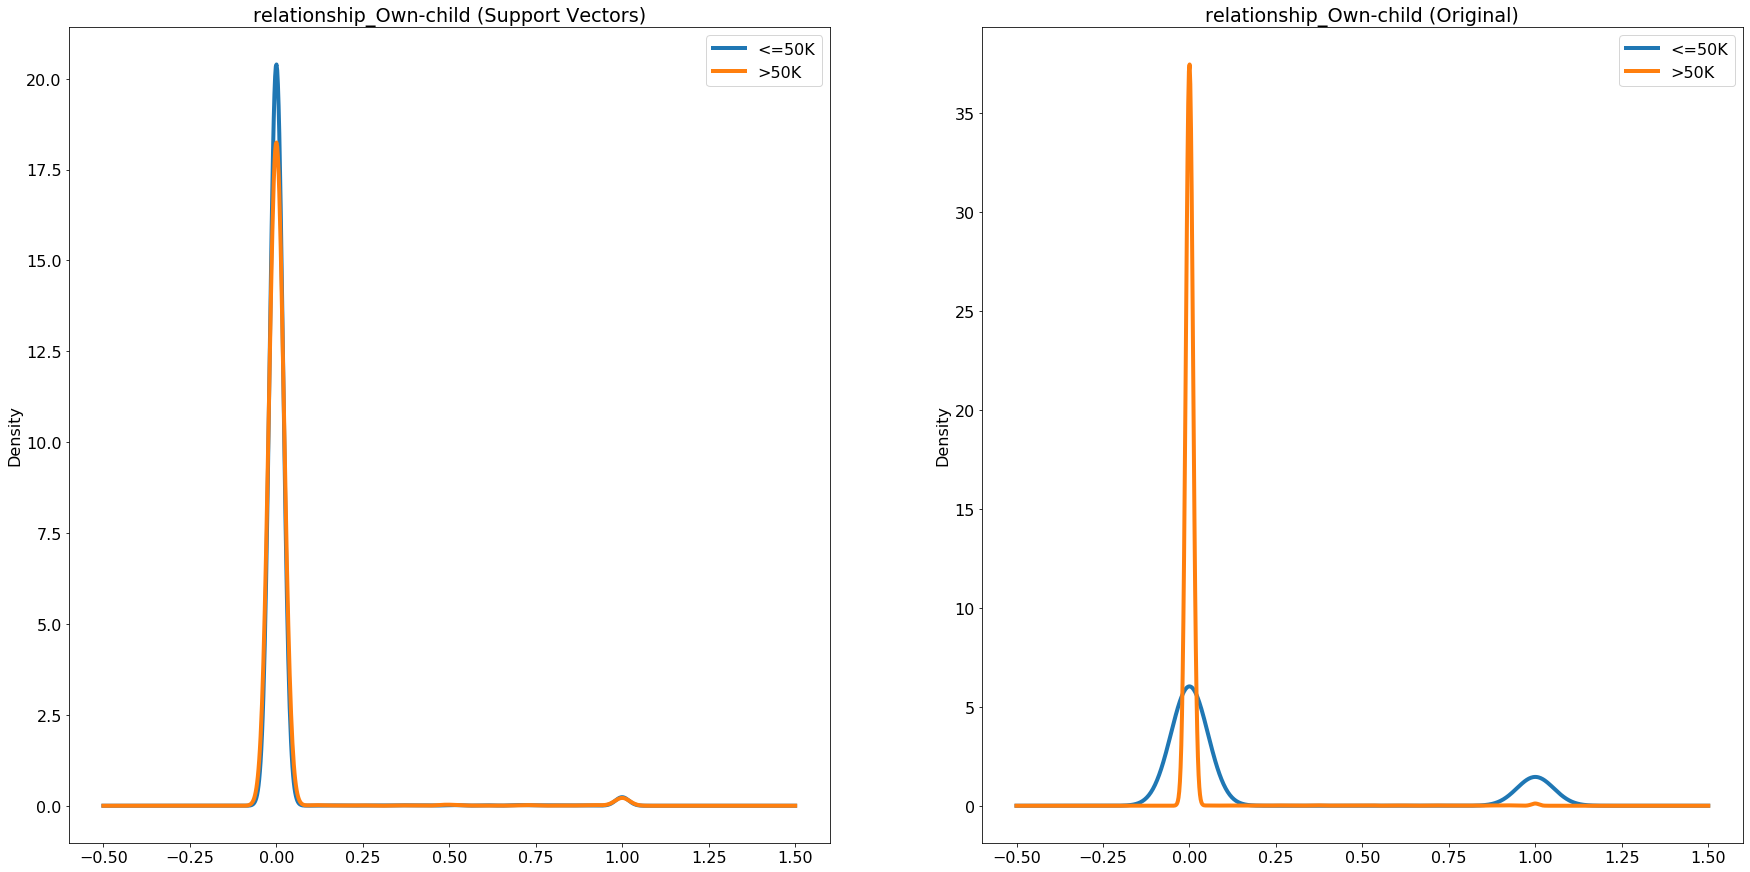

<Figure size 720x288 with 0 Axes>

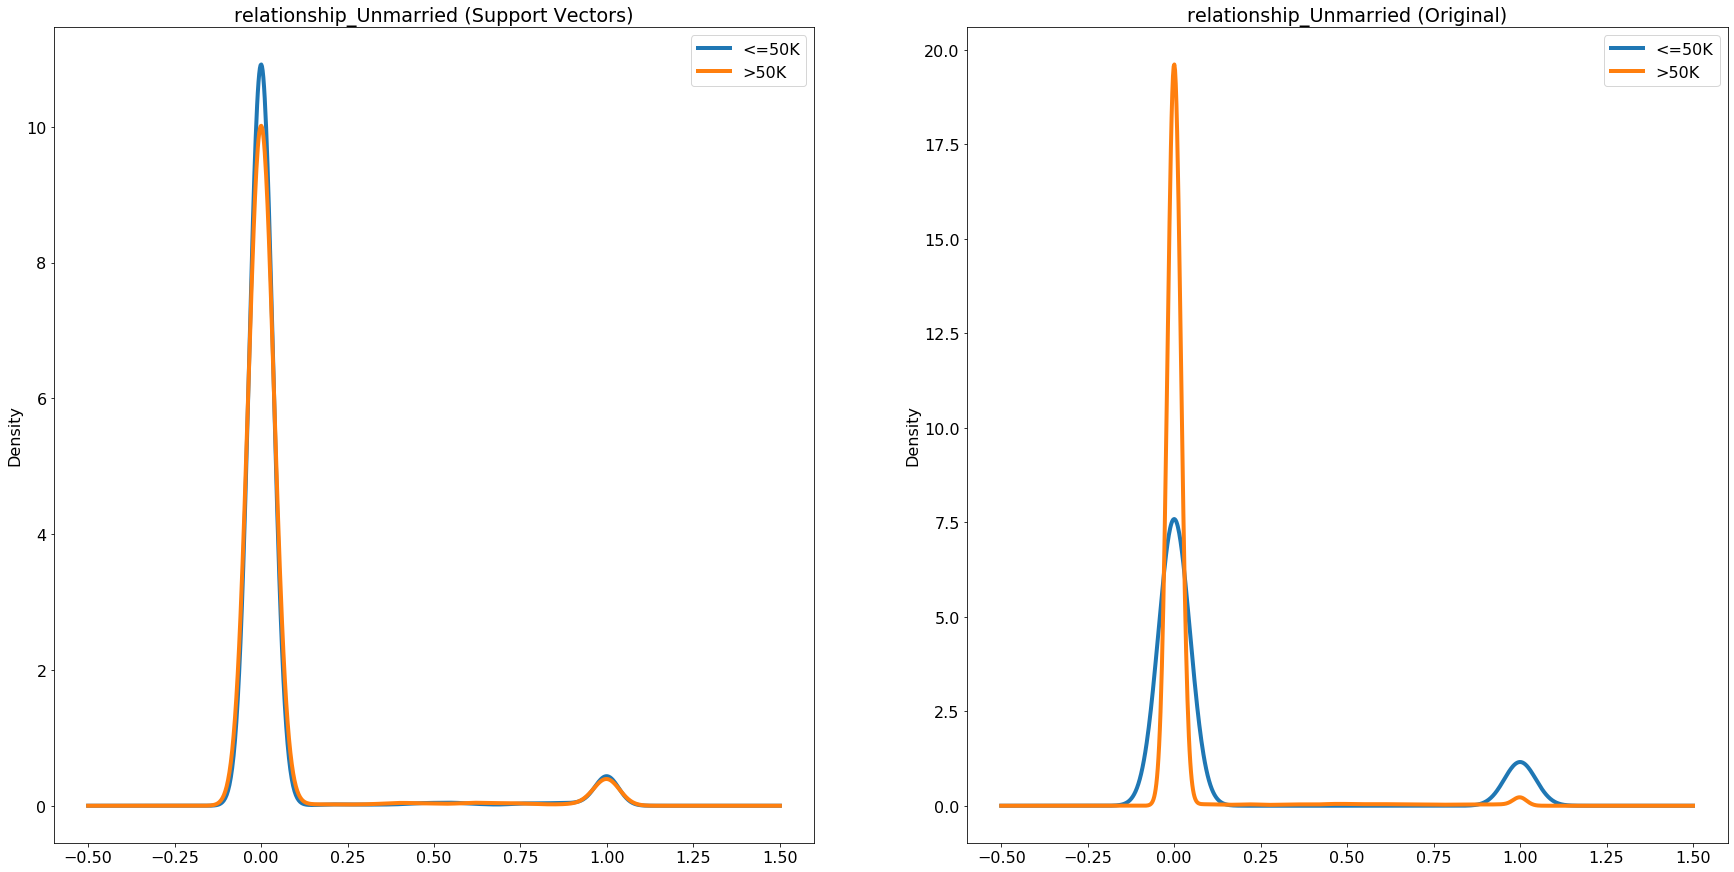

<Figure size 720x288 with 0 Axes>

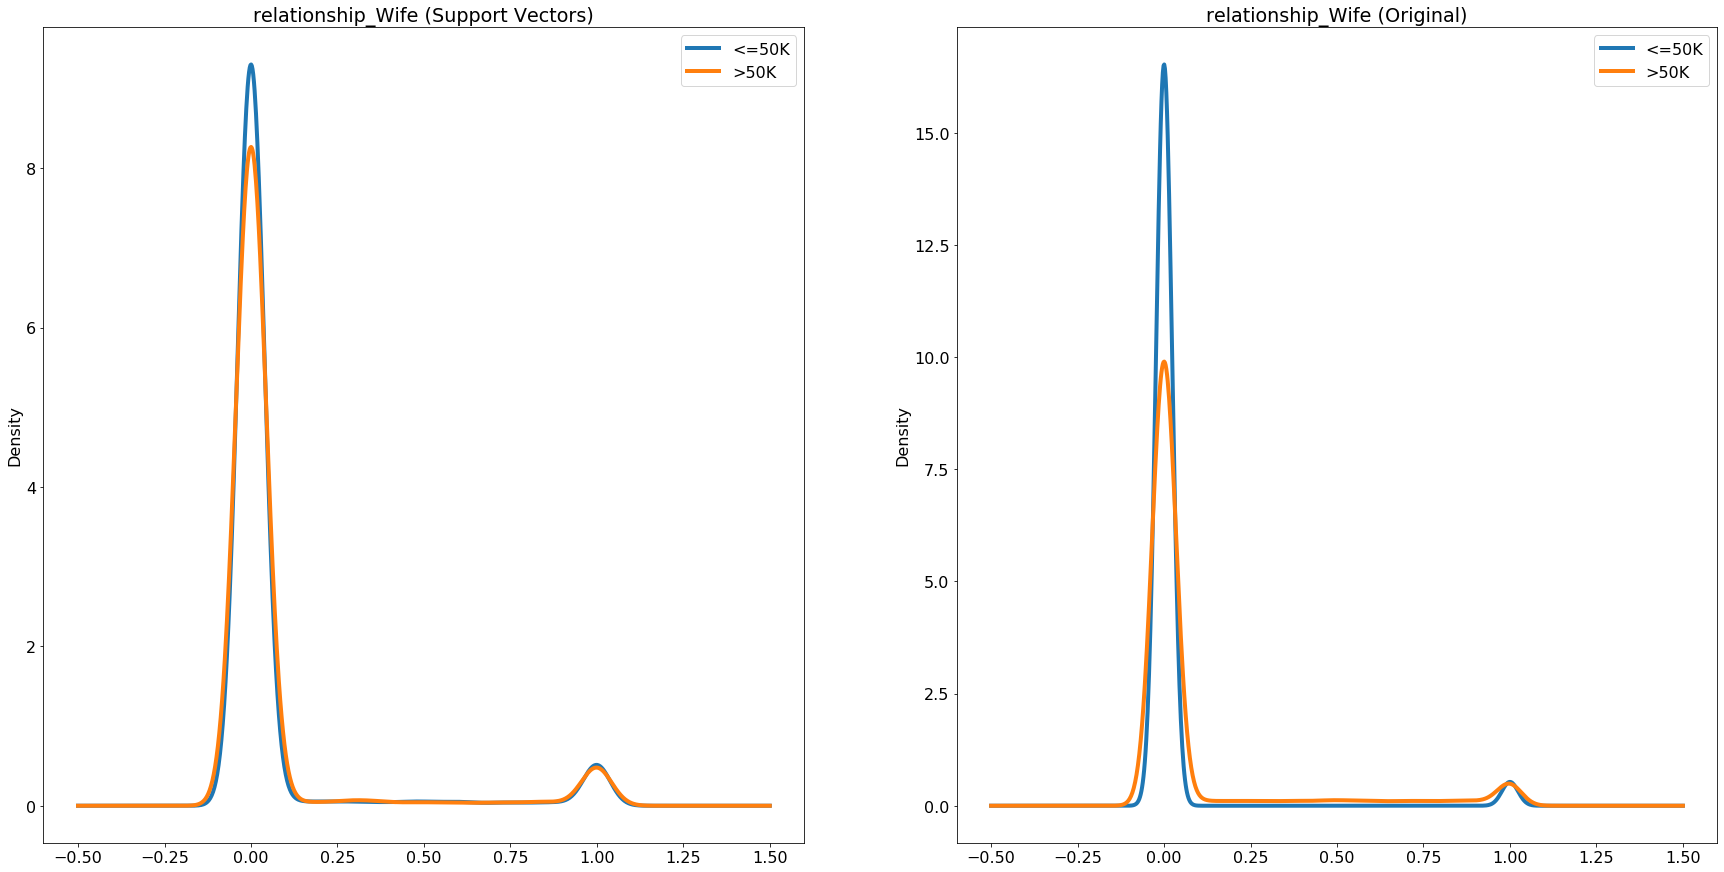

<Figure size 720x288 with 0 Axes>

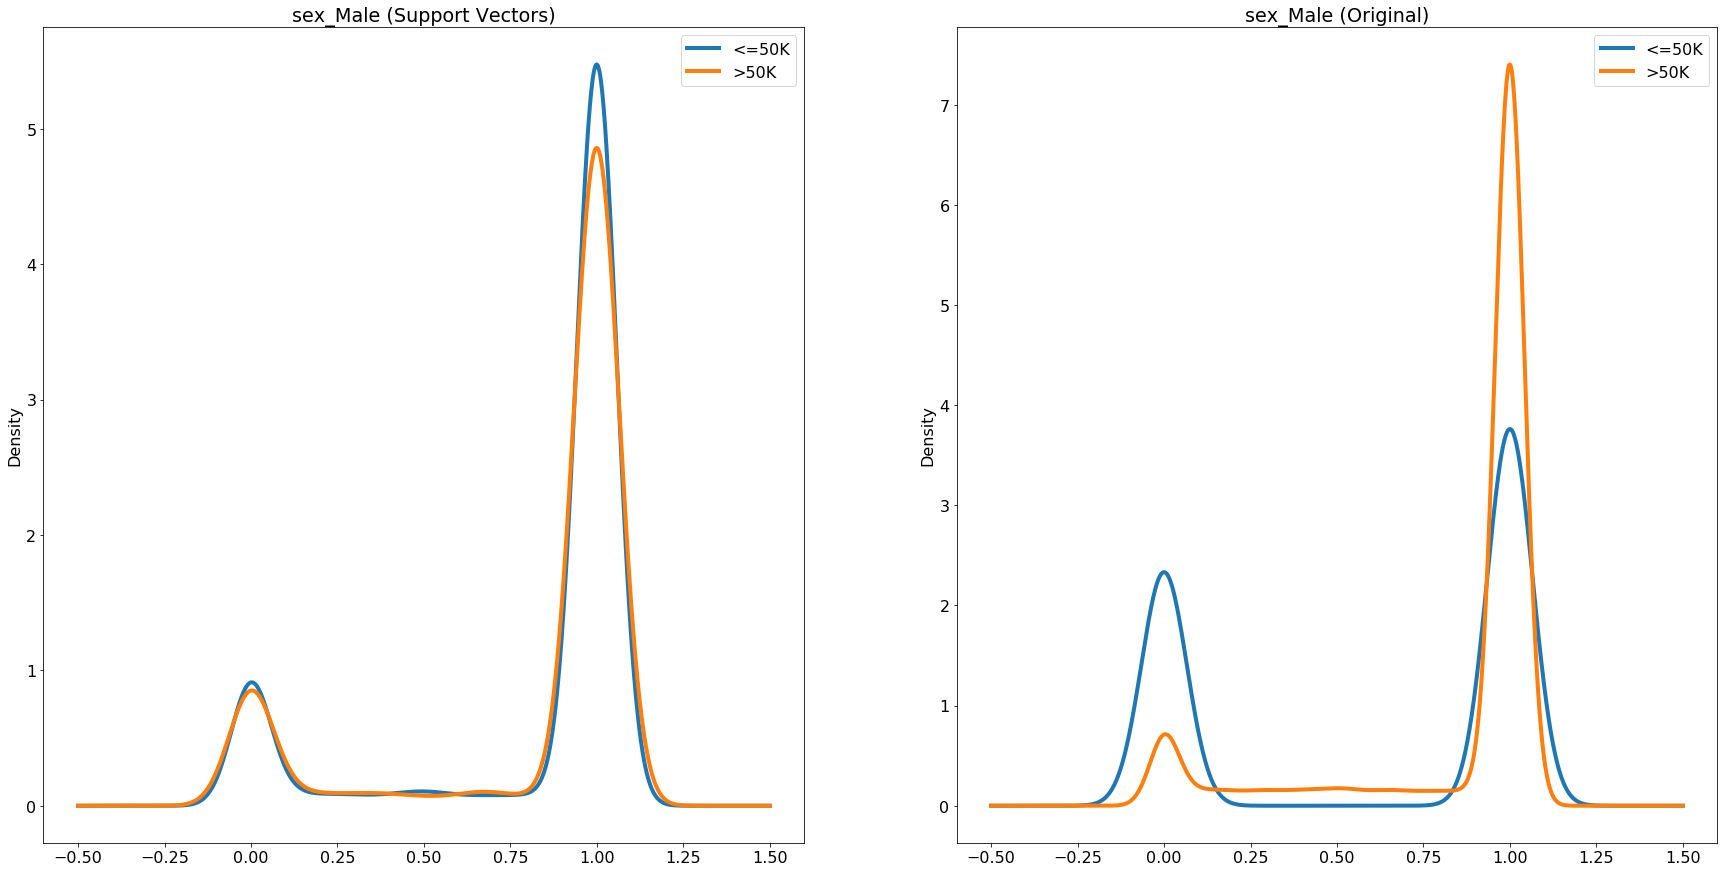

<Figure size 720x288 with 0 Axes>

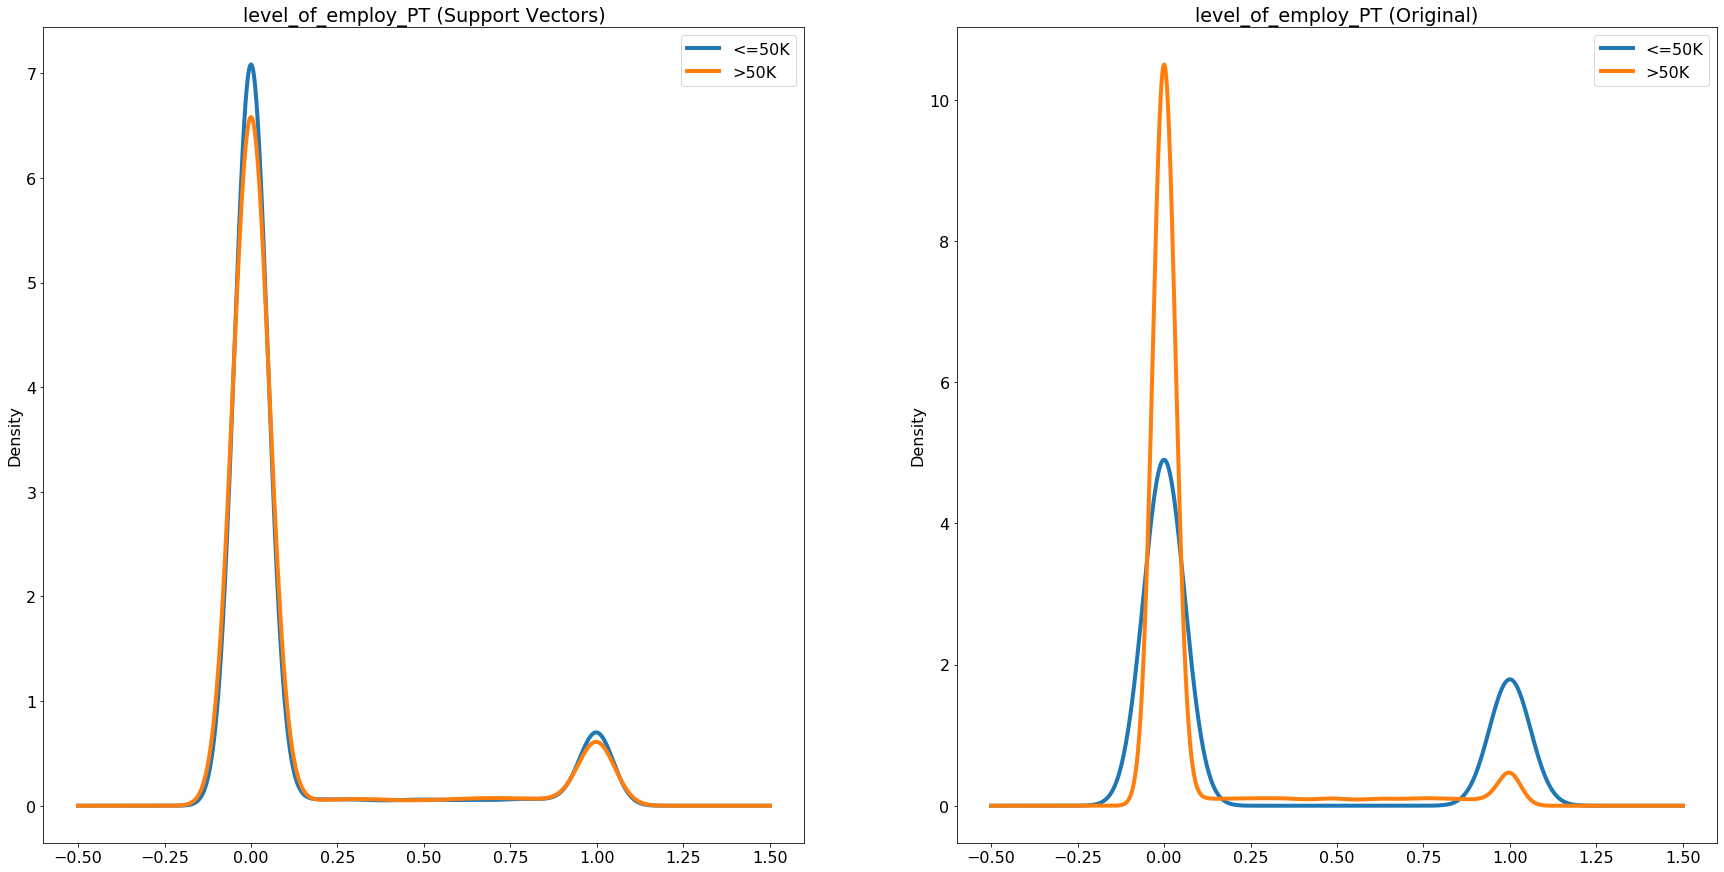

In [53]:
#Support vectors from the linear SVC model


df_tested_on = smote_df_.iloc[train_indices].copy() 
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['income_outcome'] = y_upsam_smote_[svm_clf.support_] 
df_grouped_support = df_support.groupby(['income_outcome'])
df_grouped = smote_df_.groupby(['income_outcome'])

# plot KDE of Different variables
vars_to_plot = ['education_num_yr', 'cap_gain', 'age', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'sex_Male', 'level_of_employ_PT']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    plt.figure(figsize=(30,15))
    plt.rcParams.update({'font.size': 16,'lines.linewidth':4})
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Original)')

Using linear SVC on a subsampled population, we can extract and examine the statistics for the chosen support vectors (left) compared to the density of the original data (right).  The total nuber of support vectors is 70, therefore we will look at the comparisons of the ten most important as previously identified in our EDA from lab 1: education_num_yr, cap_gain, age, relationship_Not-in-family, relationship_Other-relative, relationship_Own-child, relationship_Unmarried, relationship_Wife, sex_Male, level_of_employ_PT.

In general, we can state, we see from the train data set, X_train_scaled_smote_.shape, there are 36134 training instances. When looking at the linear support vectors, we see, 14304 support vectors were chosen for the 70 features in our model. That is to say there are 7151 negative support vectors and 7153 positive support vectors along the decision boundary.


When we compare the instances chosen as support vectors for the selected features, education_num_yr, cap_gain, age, relationship_Not-in-family, relationship_Other-relative, relationship_Own-child, relationship_Unmarried, relationship_Wife, sex_Male, level_of_employ_PT, we see the boundaries are next to each other. Where as in the original data, there is more clear linear separation in the features. This would lead us to believe we have correctly identified the linear seperable features in the data set when using logistic regression and linear support vector machines. 

Across all ten examples displayed above, we see significant decreases of the distance between the over 50,000 and the less than or equal to 50,000 distributions as the support vectors are instances close to (or on) the decision boundary.  

One outstanding example is relationship_Not-in-family.  We can see that the original data bimodal distribution has less than 50,000 with a pek around 7 with over 50,000 coming in just over 4.  In the support vecotr graph we can see that that gap is nearly closed with less than 50,000 at 5 and over 50,000 at approximately 4.5.

relationship_Other-relative is another excellent example. The original data distribution shows over 50,000 nearing 50.  While this spike is extremely thin, the speak of the under 50,000 only reaches 15.  Changing over to our support vector density plot on the left, we can see that both peaks are near 25.  Similar relationships can be observed with the relationship_own-child and relationship_Unmarried density plot comparisons as well. 


The reason for these observations is the instances chosen as support vectors fall right along the decision boundary. The only instances we choose as support vectors are instances that are next to the decision boundary and the slack variables. In other words, the support vectors aid us with the decision boundary, and the slack variables aid us with the miss-classified instances to be within the margin of the decision boundary. This is really where the decision boundary lies vs the original data, and we want that margin to be as small as possible.





# Rubric Sections

https://www.datasciencecentral.com/profiles/blogs/crisp-dm-a-standard-methodology-to-ensure-a-good-outcome

Create Models: 

50 PTS 

Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

Model Advantages: 

10 PTS 

Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

Interpret Feature Importance: 

30 PTS 

Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

Interpret Support Vectors: 

10 PTS 

Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.